# Setup

## Imports

In [ ]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import random
import pandas as pd
import os
from scipy.stats import rv_histogram
from scipy.stats import beta, gamma
import scipy as sp
from itertools import product

## Classes and Functions

### Helperfunctions and Variables

In [88]:
def spstgamma(alpha, beta):
    return sp.stats.gamma(a=alpha, scale=1/beta)

In [89]:
__colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def _colors(i):
  return __colors[i % len(__colors)]

__grey_scale = [ '#9da39a', '#7f8785', '#616b70', '#434f5b',]
__theme_color_scales = np.array([['#a4a286', '#cac7a5', '#f0ecc4'], ['#5b7fa3', '#709cc9', '#85b9ef']])
__cherry = '#db2955'

folder_path = "../simulation output/"
simulation_data_filepath = "../simulation output/sims.csv"


### SimulationFile Class

In [136]:
class SimulationFile:
  def __init__(self, groupKeys, dataframe):
    self.params = {col: dataframe[col].iloc[0] for col in groupKeys}
    #self.other = {col: np.array(dataframe[col].values) for col in dataframe.columns if col not in groupKeys}
    self.other = {}
    for col in dataframe.columns:
        if col not in groupKeys:
            if col == 'lattice':  # Special handling for lattice
                self.other[col] = np.stack(dataframe[col].values)
            else:
                self.other[col] = np.array(dataframe[col].values)
    self.params["rho_c"] = 1

  def fetch(sim, *param_names):
    return [sim.params[name] if name in sim.params else sim.other[name] for name in param_names]

  def C_L(self):
    L = self.params['L']
    rho = self.params['rho']
    rho_c = self.params['rho_c']
    theta = self.params['theta']
    k = self.params['k']
    gamma = self.params['gamma']

    if k != -2:
      return (L * (rho - rho_c) / theta / sp.special.gamma(2+k)) ** (gamma/(2+k))
    return L * (rho - rho_c)
  
  def rho_c_L(self):
    C_L = self.C_L()
    return(1-1/C_L)/(1/C_L + 1)

  def Phi_L(self, runtime):
    return np.mean((self.jumps / runtime / self.L)[:4])

  def tail(self, domain_upper_bound = None):
    lattices = self.other['lattice']
    N = self.params['N']
    C_L = self.C_L()
    etas_fl = lattices.flatten()

    if domain_upper_bound == None:
      domain_upper_bound = np.max(etas_fl)/C_L
    
    domain = np.linspace(0, domain_upper_bound, 1000)
    _tail = ((etas_fl > C_L * domain.reshape(-1, 1)) @ etas_fl) / (N * lattices.shape[0])
    return domain, _tail
  
  def _tail(sim, domain_upper_bound = None):
    lattices = np.array(sim.other['lattice'])
    print(lattices)
    N = sim.params['N']
    C_L = sim.C_L()
    etas_fl = np.array(lattices).flatten()
    print(lattices.shape)
    print(etas_fl.shape)
    if domain_upper_bound is None:
      domain_upper_bound = np.max(etas_fl)/C_L
    domain = np.linspace(0, domain_upper_bound, 1000)
    _tail = ((etas_fl > C_L * domain.reshape(-1, 1)) @ etas_fl) / (N * lattices.shape[0])
    return domain, _tail

  def empirical_distribution(self, domain_upper_bound = None):
    L = self.params['L']
    lattices = self.other['lattice']
    etas_fl = lattices.flatten()

    if domain_upper_bound == None:
      domain_upper_bound = np.max(etas_fl)
    
    domain = np.arange(domain_upper_bound + 1)
    _tail = np.sum(etas_fl <= domain.reshape(-1, 1), axis=1) / (L * lattices.shape[0])
    return domain, _tail
  
  def empirical_distribution_reordered(self, domain_upper_bound = None):
    N = self.params['N']
    lattices = self.other['lattice']
    C_L = self.C_L()
    etas_fl = lattices.flatten()

    if domain_upper_bound == None:
      domain_upper_bound = np.max(etas_fl)
    
    domain = np.arange(domain_upper_bound + 1)
    _tail = ((etas_fl <= C_L * domain.reshape(-1, 1)) @ etas_fl) / (N * lattices.shape[0])
    return domain, _tail
  
  def unordered_tail(self, domain_upper_bound = None):
    lattices = self.other['lattice']
    C_L = self.C_L()
    etas_fl = lattices.flatten()

    if domain_upper_bound == None:
      domain_upper_bound = np.max(etas_fl)/C_L

    domain = np.linspace(0, domain_upper_bound, 1000)
    cluster_count = np.sum(etas_fl > np.sqrt(C_L))
    large_count = np.sum((etas_fl > C_L * domain.reshape(-1, 1)), axis=1)
    _tail = large_count / cluster_count
    return domain, _tail

### Load and select params functions

In [120]:
data = None

def reloadData():
  global data
  data = pd.read_csv(simulation_data_filepath)
  data['L'] = data['L'].astype(int)
  data['N'] = data['N'].astype(int)
  data['lattice'] = data['lattice'].apply(lambda x: np.array([int(i) for i in x.split(',')]))

def selectDataIndices(L_rule, N_rule, k_rule, theta_rule, extra_info_rule):
  rules = [L_rule, N_rule, k_rule, theta_rule, extra_info_rule]
  allowed_operators = ['==', '!=', '>', '<', '>=', '<=']

  selection = data.iloc[:, 0] != 0 # all indeces
  for i in range(4):
    if rules[i] == '*':
      continue

    op = rules[i][:2] if rules[i][1] == '=' else rules[i][:1]
    if op not in allowed_operators:
      return selection
    
    if op == '==':
      selection = selection & (data.iloc[:, i] == float(rules[i][2:]))
    elif op == '!=':
      selection = selection & (data.iloc[:, i] != float(rules[i][2:]))
    elif op == '>':
      selection = selection & (data.iloc[:, i] > float(rules[i][1:]))
    elif op == '<':
      selection = selection & (data.iloc[:, i] < float(rules[i][1:]))
    elif op == '>=':
      selection = selection & (data.iloc[:, i] >= float(rules[i][2:]))
    elif op == '<=':
      selection = selection & (data.iloc[:, i] <= float(rules[i][2:]))


  if rules[4] != '*':
    selection = selection & (data.iloc[:, 4] == rules[4])
  return selection

def groupedSims(group_keys = ['L','N','k','theta','extra_info','gamma','rho','initial_conditions','runtime'], df = None):
  if df is None:
    df = data
  grpd = df.groupby(group_keys)
  return [SimulationFile(group_keys, group_df) for _, group_df in grpd]

### Check if Simulation Data is Corrupted

In [92]:
reloadData()

for _, row in data.iterrows():
  if np.sum(row['lattice']) != row['N'] or len(row['lattice']) != row['L']:
    print(row)

### Plotting Setup

In [93]:
#plt.rcParams.update({"font.size": 16})

def dynamic_fontsize(fig, base_size=4):
    width, height = fig.get_size_inches()  # Get figure size in inches
    return base_size * (np.sqrt(width * height)/ 6)  # Adjust scale factor as needed


def drawGraphs(
  cols: int,
  rows: int,
  col_weights: int,
  row_weights: int,
  graph_factory: callable,
  save_settings = None,
  font_size = 'small'
  ):

  column_width_ratios = np.tile(col_weights, cols)
  row_height_ratios = np.tile(row_weights, rows)

  fig = plt.figure(figsize=(cols * sum(col_weights) * 16, rows * sum(row_weights) * 9))
  fontsize = {'small' : 8, 'large': 14, 'huge': 20}[font_size]
  plt.rcParams.update({"font.size": fontsize})

  gs = fig.add_gridspec(
    len(row_weights) * rows,
    len(col_weights) * cols, 
    width_ratios=column_width_ratios * cols,
    height_ratios=row_height_ratios * rows,
    wspace=0.1, hspace=0.1)

  for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        
        allotted_axes = \
        np.array([
          [
            fig.add_subplot(gs[
              i * len(row_weights) + row_ax_idx,
              j * len(col_weights) + col_ax_idx])
            for row_ax_idx in range(len(row_weights))
          ]
          for col_ax_idx in range(len(col_weights))
        ])

        graph_factory(allotted_axes, idx)

  #plt.tight_layout()

  if save_settings is None:
    plt.show()
    return

  plt.savefig(
    save_settings["path"],
    bbox_inches='tight',
    pad_inches=0.1
  )


## Paper Function Definitions

### Not Z_L

In [27]:
infty = 10000

def C(L, rho, k, theta):
  rho_c = 1
  return (L * (rho - rho_c) / theta / sp.special.gamma(2 + k)) ** (1/(2 + k))

def Phi(L, rho, k, theta):
  return 1 - 1 / C(L, rho, k, theta)

def rho_c(L, rho, k, theta):
  C_L = C(L, rho, k, theta)
  return (1 - 1 / C_L) / (1 + 1 / C_L)

def scaled_gamma_tail(L, rho, k, theta, domain):
  rho_c_L = rho_c(L, rho, k, theta)
  factor_L = (rho - rho_c_L) / rho
  return 1 - (1 - factor_L) - factor_L * spstgamma(k+2, 1).cdf(domain)

def _w(n):
  return np.power(2.0, -n-1)

def w(L, theta, k, n):
  return _w(n) + theta/L * np.power(n+1, k)

def z(L, theta, k, phi):
  n = np.arange(infty).astype(float)
  return np.sum(np.power(phi[:, np.newaxis], n) * w(L, theta, k, n), axis=1)

def _z(phi):
  n = np.arange(infty).astype(float)
  return np.sum(np.power(phi[:, np.newaxis], n) * _w(n), axis=1)

def dz_dphi(L, theta, k, phi):
  n = np.arange(1, infty).astype(float)
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * w(L, theta, k, n), axis=1)

def _dz_dphi(phi):
  n = np.arange(1, infty).astype(float)
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * _w(n), axis=1)

def R(L, theta, k, phi):
  return phi * dz_dphi(L, theta, k, phi) / z(L, theta, k, phi)

def _R(phi):
  return -phi/(phi - 2)
  #return phi * _dz_dphi(phi) / _z(phi)

def _Phi(rho):
  return np.where(rho > 1, 1, 2 * rho / (1 + rho))

def Z(E, N, w_array):
    Z = w_array.copy()
    znew = w_array.copy()
    for _ in range(E):
      for j in range(N+1):
        znew[j] = np.sum(Z[:j+1] * Z[j::-1])
      Z = znew.copy()
    return Z

def current(ZL, N):
  return [k / N for k in range(1, N)], [ ZL[k] / ZL[k + 1] for k in range(1, N)]

### Load Z_{L,N}

In [ ]:
%%cython -f
import numpy as np
cimport numpy as cnp
from itertools import product
import pandas as pd
import os

cdef double _w_element(int n):
    return pow(2.0, -n - 1)

cdef double w_element(int L, double theta, double k, int n):
    return _w_element(n) + theta / L * pow(n + 1, k)

cpdef cnp.ndarray w_array_func(int L, double theta, double k, int N):
    cdef cnp.ndarray[double, ndim=1] w_array = np.empty(N + 1, dtype=np.float64)
    cdef int n
    for n in range(N + 1):
        w_array[n] = w_element(L, theta, k, n)
    return w_array

cpdef cnp.ndarray convolve(cnp.ndarray[double, ndim=1] a, cnp.ndarray[double, ndim=1] b):
    cdef int len_a = a.shape[0]
    cdef int len_b = b.shape[0]
    cdef int result_len = len_a + len_b - 1
    cdef cnp.ndarray[double, ndim=1] result = np.zeros(result_len, dtype=np.float64)
    cdef int i, j

    for i in range(len_a):
        for j in range(len_b):
            result[i + j] += a[i] * b[j]
    return result

cpdef cnp.ndarray Z(int E, int N, cnp.ndarray[double, ndim=1] w_array):
    cdef cnp.ndarray[double, ndim=1] Z = w_array.copy()
    cdef cnp.ndarray[double, ndim=1] temp = np.zeros(Z.shape[0], dtype=np.float64)
    cdef int j, k

    for _ in range(E):
        for j in range(N+1):
            temp[j] = 0
            for k in range(j+1):
                temp[j] += Z[k] * Z[j - k]
        Z = temp.copy()
    return Z

def generate_Z_csv():
    cdef:
        list EE = [7, 8, 9, 10, 11, 12, 13,]
        list kk = [-0.5, 0, 0.5, 1.5, 2.5]
        list tt = [10, 1, 0.1]
        list rr = [2, 4]
        object params = list(product(kk, rr, tt))
        int E, L, N, n
        double theta, k, rho
        list df_rows_new = []
    
    df_Z = None
    print("Checking for existing file...")
    if os.path.exists('Z.csv'):
        print("File exists. Loading...")
        df_Z = pd.read_csv('Z.csv')
        print(df_Z.head())
    
    print("Generating new data...")
    for k, rho, theta in params:
        for E in EE:
            L = pow(2, E)
            N = int(rho * L)
            print(f"Processing: k={k}, rho={rho}, theta={theta}, E={E}, L={L}, N={N}")

            if df_Z is not None:
                indeces \
                    = (df_Z['k'] == k) \
                    & (df_Z['rho'] == rho) \
                    & (df_Z['theta'] == theta) \
                    & (df_Z['L'] == L)
                count = df_Z[indeces].shape[0]
                if count == N + 1:
                    print("Data already exists. Skipping...")
                    continue
                if count > 0:
                    print(f"Data exists but is incomplete, available {count/(N+1) * 100:.1f} %")
                    continue

            w_array = w_array_func(L, theta, k, N)
            Z_array = Z(E, N, w_array)
            for n in range(N + 1):
                df_rows_new.append((k, rho, theta, L, n, Z_array[n]))
    
    print(f"Total new rows generated: {len(df_rows_new)}")
    df_Z_new = pd.DataFrame(
        df_rows_new,
        columns=['k', 'rho', 'theta', 'L', 'n', 'Z_{L,n}']
    )
    df_Z = pd.concat([df_Z, df_Z_new], ignore_index=True)
    df_Z = df_Z.dropna()
    df_Z.sort_values(by=['k', 'rho', 'theta', 'L', 'n'], inplace=True)
    print("Saving CSV to file...")
    df_Z.to_csv('Z.csv', index=False)
    print("CSV saved successfully!")
    return df_Z

df_Z = generate_Z_csv()
df_Z = df_Z.set_index(['k', 'rho', 'theta', 'L', 'n'])

# Paper Functions

## Plot $R_L$, $R$

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26832\4018066092.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26832\3393806143.py:32: RuntimeWarning: overflow encountered in power
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * w(L, theta, k, n), axis=1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26832\3393806143.py:32: RuntimeWarning: overflow encountered in multiply
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * w(L, theta, k, n), axis=1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26832\3393806143.py:24: RuntimeWarning: overflow encountered in power
  return np.sum(np.power(phi[:, np.newaxis], n) * w(L, theta, k, n), axis=1)
C:\Users\Public\Documents\Wondershar

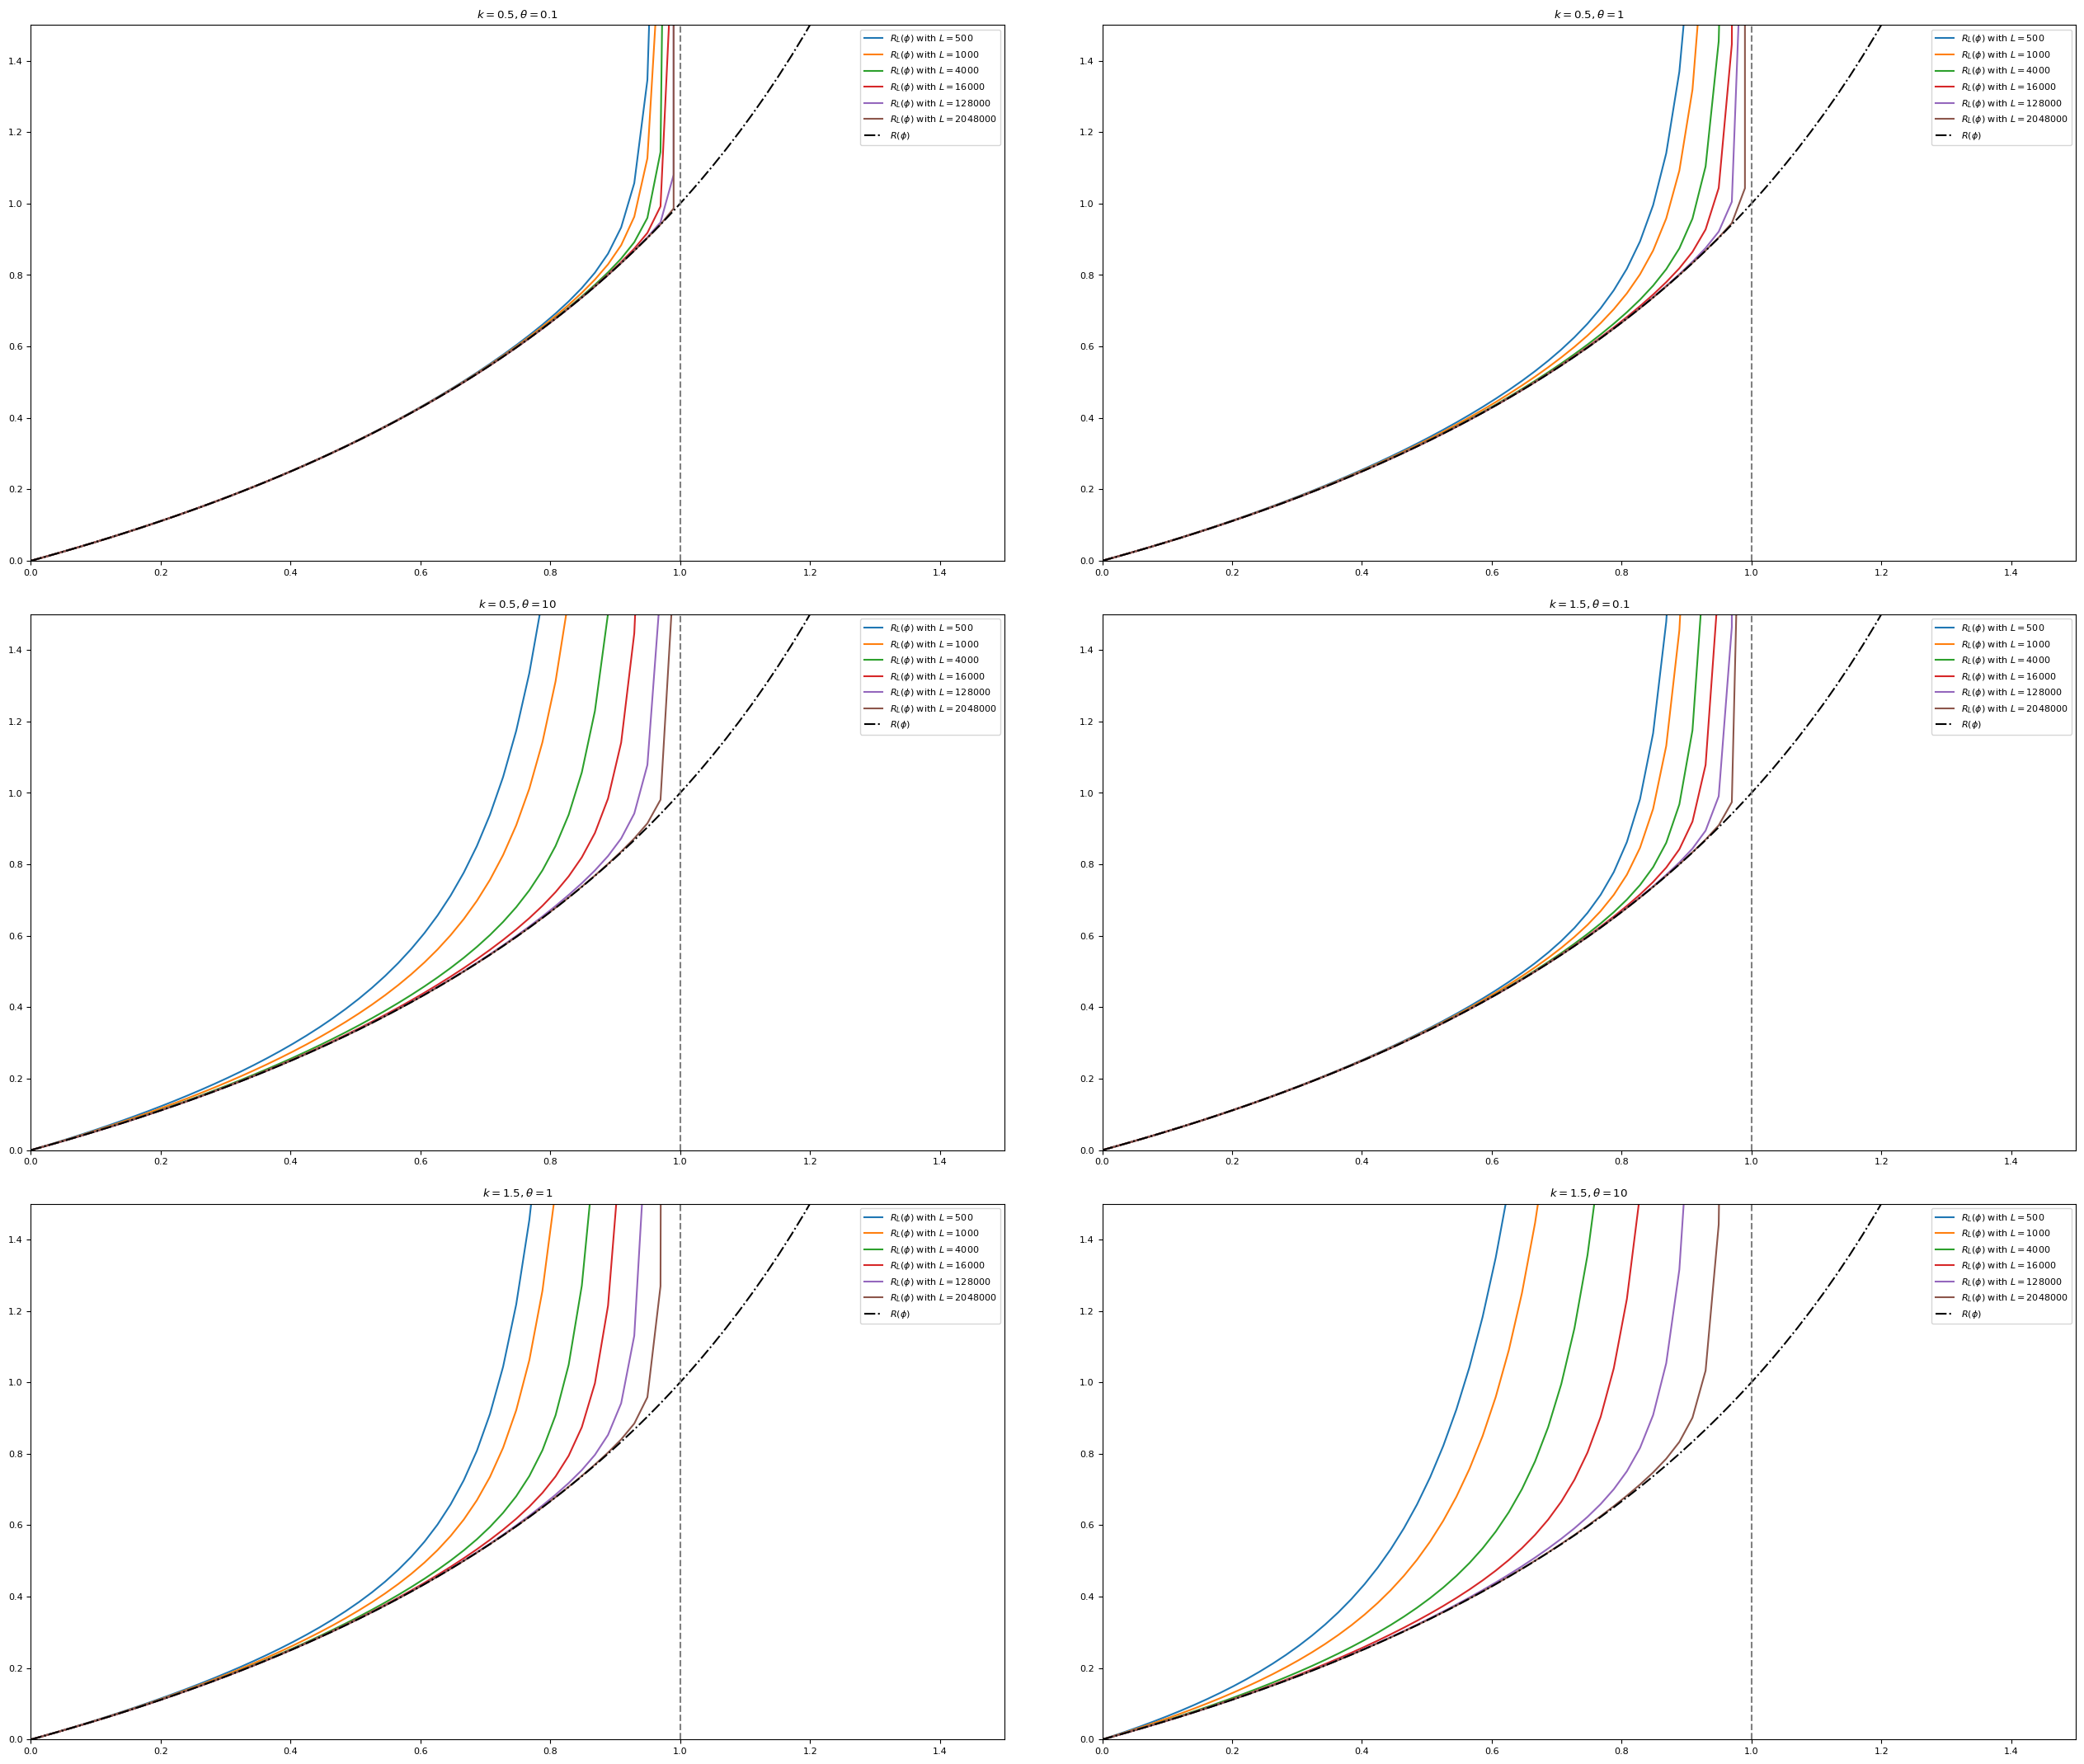

In [23]:
ks = [0.5, 1.5]
thetas = [0.1, 1, 10]
ksXthetas = list(product(ks, thetas))
Ls = [500, 1000, 4000, 16000, 16000*8, 16000*8*16]

rnge = 1
x_min, x_max = 1 - rnge, 1 + rnge
phi_domain = np.linspace(x_min, x_max, 100)
cmap = cm.get_cmap('hot')


def graphRL(axs, idx):
  axs = axs[0,0]
  (k, theta) = ksXthetas[idx]
  for i, L in enumerate(Ls):
    axs.set_title(f"$k={k}, \\theta={theta}$")
    axs.plot(
      phi_domain,
      R(L, theta, k, phi_domain),
      #[R(L, theta, k, phi) for phi in phi_domain],
      #color=cmap(1-i / len(Ls)),
      label=f"$R_L(\\phi)$ with $L={L}$")

  _R_phi = _R(phi_domain) #[_R(phi) for phi in phi_domain]
  axs.plot(phi_domain, _R_phi, color="black", label="$R(\phi)$", linestyle='-.')
  axs.set_xlim(0, 1.5)
  axs.set_ylim(0, 1.5)
  axs.vlines(1, 0, 200, color="gray", linestyle="--")
  axs.legend()

drawGraphs(
  cols=2, rows=3,
  col_weights=[1], row_weights=[1],
  graph_factory=graphRL)

## $Z_{L,n}$ Plot

In [ ]:
ks = df_Z.index.unique('k').to_numpy()
rhos = [2]#df_Z.index.unique('rho').to_numpy()
thetas = [0.1]#df_Z.index.unique('theta').to_numpy()

params = list(product(ks, rhos, thetas))
Es = np.log2(df_Z.index.unique('L')).to_numpy()

print(ks, rhos, thetas, Es, df_Z.index.unique('L').to_numpy())

In [ ]:
c1 = {}
c2 = {}
c3 = {}
#q = {}
for k, rho, theta in params:
  _Z = df_Z.loc[k, rho, theta]
  c1s = []
  c2s = []
  c3s = []
  #qs = []
  for e1 in Es:
    for e2 in Es:
      if e2 <= e1: continue # e2 > e1

      Lmin = 2**e1
      Lmax = 2**e2
      _Z_Lmin = _Z.loc[Lmin]
      _Z_Lmax = _Z.loc[Lmax]

      Nmin = rho * Lmin
      Nmax = rho * Lmax

      if _Z_Lmin.shape[0] != Nmin + 1 or _Z_Lmax.shape[0] != Nmax + 1:
        continue

      _Z_LNmin = _Z_Lmin.loc[Nmin]
      _Z_LNmax = _Z_Lmax.loc[Nmax]

      c1s.append(np.log(_Z_LNmax/_Z_LNmin)/(rho - 1)**0.5/(Lmax**0.5 - Lmin**0.5))
      c2s.append(
        np.log(_Z_LNmax/_Z_LNmin) \
        /(np.power(Lmax*(rho - 1), 1-1/(k+2)) * np.power(theta * sp.special.gamma(k+2), 1/(k+2)) - \
          np.power(Lmin*(rho - 1), 1-1/(k+2)) * np.power(theta * sp.special.gamma(k+2), 1/(k+2)))
      )
      c3s.append(np.log(_Z_LNmax/_Z_LNmin)/(Lmax*np.log(Lmax) - Lmin*np.log(Lmin)))
      #qs.append(np.log(_Z_LNmin/_Z_LNmax)/np.log(Lmax/Lmin))
  

  c1[k, rho, theta] = (np.min(c1s), np.max(c1s))
  c2[k, rho, theta] = (np.min(c2s), np.max(c2s))
  c3[k, rho, theta] = (np.min(c3s), np.max(c3s))
  #q[k, rho, theta] = (np.min(qs), np.max(qs))

print(c1)
print(c2)
print(c3)
#print(q)

c1 = {
  (-0.5, 2):  c1[-0.5, 2, 1][0] + 0.2 * (c1[-0.5, 2, 1][1] - c1[-0.5, 2, 1][0]),
  (0, 2):     c1[0, 2, 1][0] + 0.1 *    (c1[0, 2, 1][1] -    c1[0, 2, 1][0]), 
  (0.5, 2):   c1[0.5, 2, 1][0] + 0.3 *  (c1[0.5, 2, 1][1] -  c1[0.5, 2, 1][0]),
  (1.5, 2):   c1[1.5, 2, 1][0] + 0.3 *  (c1[1.5, 2, 1][1] -  c1[1.5, 2, 1][0])
}

c2 = {
  (-0.5, 2):  c2[-0.5, 2, 1][0] + 1.0 * (c2[-0.5, 2, 1][1] - c2[-0.5, 2, 1][0]),
  (0, 2):     c2[0, 2, 1][0] +    1.0 * (c2[0, 2, 1][1] -    c2[0, 2, 1][0]), 
  (0.5, 2):   c2[0.5, 2, 1][0] +  1.0 * (c2[0.5, 2, 1][1] -  c2[0.5, 2, 1][0]),
  (1.5, 2):   c2[1.5, 2, 1][0] +  1.0 * (c2[1.5, 2, 1][1] -  c2[1.5, 2, 1][0])
}

c3 = {
  (-0.5, 2):  c3[-0.5, 2, 1][0] + 0.5 * (c3[-0.5, 2, 1][1] - c3[-0.5, 2, 1][0]),
  (0, 2):     c3[0, 2, 1][0] +    0.5 * (c3[0, 2, 1][1] -    c3[0, 2, 1][0]), 
  (0.5, 2):   c3[0.5, 2, 1][0] +  0.5 * (c3[0.5, 2, 1][1] -  c3[0.5, 2, 1][0]),
  (1.5, 2):   c3[1.5, 2, 1][0] +  0.5 * (c3[1.5, 2, 1][1] -  c3[1.5, 2, 1][0])
}
#q = {
#  (-0.5, 2): q[-0.5, 2, 1][0] + 0.9 * (q[-0.5, 2, 1][1] - q[-0.5, 2, 1][0]),
#  (0, 2):   q[0, 2, 1][0]   + 0.8 * (q[0, 2, 1][1] -   q[0, 2, 1][0]), 
#  (0.5, 2): q[0.5, 2, 1][0] + 0.7 * (q[0.5, 2, 1][1] - q[0.5, 2, 1][0]),
#  (1.5, 2): q[1.5, 2, 1][0] + 0.84 * (q[1.5, 2, 1][1] - q[1.5, 2, 1][0])
#}

In [ ]:
def ZLnPlots(axs, idx):
  axs = axs[0,0]
  if idx >= len(params):
    return


  k, rho, theta = params[idx]

  _Z = df_Z.loc[k, rho, theta]
  start_x = 1
  for e in Es[::-1]:
    L = 2**e

    if (L == 8192 and k == 1.5):
      continue

    N = rho * L
    domain = np.arange(1, N+1)/L
    start_index = int(start_x * L)
    ZL = _Z.loc[L].replace([np.inf, -np.inf], np.nan)
    if ZL.shape[0] != N + 1:
      continue

    
    #scaled_gross = np.exp(-c1[k, rho] * (rho - 1)**0.5 * L**0.5)
    #scaled_blank = np.exp(-c2[k, rho]  * np.power(L*(rho - 1), 1-1/(k+2)) * np.power(theta * sp.special.gamma(k+2), 1/(k+2)))
    #scaled_superexp = np.exp(-c3[k, rho] * L * np.log(L))

    scaling = sp.special.gamma(k+1) * np.exp(k)/(L**k * np.sqrt(2 * np.pi * (L+k))) \
      * (theta * rho**k * np.exp(1))**L * np.exp((k-2) * L * np.log(L))

    print(scaling, 1/scaling)

    axs.plot(domain[start_index:], ZL[1 + start_index:] / scaling,
     '--', label=f"$Z_{{L, n}}$ for $L={L}, n=1..N$")

  axs.vlines(1, 0, 1, 'gray', '-.', transform=axs.get_xaxis_transform())
  axs.set_yscale('log')
  axs.set_title(f"$k={k}, \\rho={rho}, \\theta={theta}$")
  axs.legend()

drawGraphs(
  cols=2, rows=3,
  col_weights=[1], row_weights=[1],
  graph_factory=ZLnPlots)

## $Z_{L,n}/Z_{L, n+1}$ Plot

In [ ]:
E = 13
theta = 0.01
for k in [-3, -2, -1, 0, 1]:
  for rho in [2]:
    L = 2**E
    N = rho * L
    w_array = w(L, theta, k, np.arange(N + 1).astype(float))
    x, y = current(Z(E, N, w_array))
    plt.plot(x, y, label=f"theta={theta}, k={k}, rho={rho}, L={2**E}")

plt.legend()
plt.show()

## $Z_{L,N-n}/Z_{L+1,N}$ and $\pi_{L+1}[\tilde{\eta}_1/C_{L+1} <= n]$

In [ ]:
def ZLNn_by_ZL1N(E, rho, k=1, theta=1):
  L = 2**E
  N = rho * (L + 1)
  NN = np.arange(N + 1).astype(np.longdouble)

  wL1_array = w(L + 1, theta, k, NN)
  ZL = Z(E, N, wL1_array)
  ZL1N = np.sum(wL1_array * Z(E, N, wL1_array)[::-1])

  return NN, wL1_array, ZL[::-1] / ZL1N

In [ ]:
def plotZoZ(axs, E, k, rho, theta):
  L = 2**E
  NN, wL1, ZoZ = ZLNn_by_ZL1N(E, rho, k, theta)
  N = NN[-1]
  factor = (L + 1)/N * NN * wL1
  pi = factor * ZoZ
  #pi /= np.sum(pi)
  pi_tail = 1 - np.cumsum(pi)
  C_L1 = C(L+1, rho, k, theta)

  pi_tail = np.nan_to_num(pi_tail, nan=0.0)
  diff = np.abs(np.diff(pi_tail))
  indices = np.where(diff <= 1e-10)[0]
  n_max = indices[0] + 1 if indices.size > 0 else int(N)
  if n_max == int(N):
    print(L, k, rho, theta)
    print(diff[::len(diff)//10])


  axs[0].plot(NN, ZoZ, label=f"$Z_{{L, N-n}}/Z_{{L+1,N}}$ $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$")
  axs[0].plot(NN/C_L1, np.exp(-NN/C_L1), label=f"ZoZ $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$")

  axs[0].plot(NN/C_L1, ZoZ, label=f"Z_{{L, N-C_Ls}}/Z_{{L+1,N}} $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$")
  axs[0].plot(NN/C_L1, np.exp(-NN/C_L1), label=f"ZoZ $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$")


  axs[2].plot(
    NN[1:n_max] / C_L1,
    pi_tail[1:n_max],
    label=f"pi[eta/C_L > n] $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$",
    color=_colors(L))

  domain = np.linspace(0, n_max/C_L1, 1000)
  sgt = scaled_gamma_tail(L + 1, rho, k, theta, domain)
  axs[2].plot(
    domain,
    sgt,
    '-.',
    label=f"eta-tail $\\theta={theta}, k={k}, \\rho={rho}, L={2**E}$",
    color=_colors(L))

def plotMultipleZoZ(axs, idx):
  axs = [axs[0,0], axs[1,0], axs[2,0]]
  if idx >= len(params):
    return
  
  k, rho, theta = params[idx]
  for E in Es:
    plotZoZ(axs, E, k, rho, theta)
  axs[0].legend()
  axs[1].legend()
  axs[2].legend()
  axs[0].set_yscale('log')
  axs[1].set_yscale('log')
  axs[2].set_yscale('log')
  #axs[1].set_xlim(0,10)
  #axs[1].set_ylim(2 * 1e-3, 1)

Es = [8, 9, 10, 11, 12]
ks = [0, 1, 1.5, 2, 2.5]
rhos = [2]
thetas = [1] # [0.1, 1, 10]
params = list(product(ks, rhos, thetas))
drawGraphs(
  cols=1, rows=len(params),
  col_weights=[1, 1, 1], row_weights=[1],
  graph_factory=plotMultipleZoZ)

## $\pi_{L+1}[\tilde{\eta}_1/C_{L+1} = n]$ detailed

In [ ]:
rr = [2, 4]
kk = [0, 1, 1.5, 2, 2.5]
tt = [0.1, 1]
params = [(2, 1, 1)]#list(product(rr, kk, tt))


def graphPdfEta(axs, idx):
  axlu, axmu, axru = axs[0, 0], axs[1, 0], axs[2, 0]
  axll, axml, axrl = axs[0, 1], axs[1, 1], axs[2, 1]

  rho, k, theta = params[idx]
  EE = [7, 8, 9]
  maxE = np.max(EE)
  maxL = np.longdouble(2)**maxE
  maxL1 = maxL + 1
  maxN = rho * maxL
  maxRhoL1 = maxN/maxL1
  maxC_L1 = (maxL1 * (maxRhoL1 - 1) / theta / sp.special.gamma(2+k)) ** (1/(2+k))
  domain = np.arange(maxN + 1).astype(np.longdouble)/maxC_L1

  for E in EE:
    NN, pi_L1N = eta_pdf(E, rho, k, theta)
    N = len(NN) - 1
    eta_cdf = 1-np.cumsum(pi_L1N)

    L = np.longdouble(2)**E
    rhoL1 = N/(L + 1)
    C_L1 = ((L+1) * (rhoL1 - 1) / theta / sp.special.gamma(2+k)) ** (1/(2+k))

    rho_cL = (1-1/C_L1)/(1/C_L1 + 1)
    rho_c = 1
    factor_cL = (rhoL1 - rho_cL)/rhoL1
    factor_c = (rhoL1 - rho_c)/rhoL1

    G_cL = (1 - (1-factor_cL) - factor_cL * spstgamma(k + 2, 1).cdf(domain))
    G_c = (1 - (1-factor_c) - factor_c * spstgamma(k + 2, 1).cdf(domain))

    paramDescription = f"$k={k}, \\theta={theta}$\n"

    f = 3 * 1/100
    axlu.plot(NN, pi_L1N, label=f"$L={L}, N/(L+1)={N/(L+1)}$")
    axlu.set_xlim(0, N * f)
    axlu.set_title(paramDescription + "$\\pi_{L+1,N}[\\tilde{\\eta}_1 = n]$ " \
      + f"for $n \\in \{{0, ..., {f}N\}}$")

    axmu.plot(NN, pi_L1N, label=f"$L={L}, N/(L+1)={N/(L+1)}$")
    axmu.set_xlim(N * f, N)
    axmu.set_title(paramDescription + "$\\pi_{L+1,N}[\\tilde{\\eta}_1 = n]$ " \
      + f"for $n \\in \{{{f}N, ..., N\}}$")

    axru.plot(NN, pi_L1N, label=f"$L={L}, N/(L+1)={N/(L+1)}$")
    axru.set_yscale('log')
    axru.set_title(paramDescription + "$\\pi_{L+1,N}[\\tilde{\\eta}_1 = n]$ " \
      + "for $n \\in \{{0, ..., N\}}$ with logscale")

    m = int(0.4 * N)
    axll.plot(NN[:m], eta_cdf[:m], label=f"$L={L}, N/(L+1)={N/(L+1)}$")
    axll.set_yscale('log')
    axll.set_title(paramDescription + "$\\pi_{L+1,N}[\\tilde{\\eta}_1 > n]$ " \
      + f"with logscale")

    axml.plot(NN[:m]/C_L1, eta_cdf[:m], label=f"$L={L}, N/(L+1)={N/(L+1)}$")
    axml.set_yscale('log')
    axml.set_title(paramDescription + "$\\pi_{L+1,N}[\\tilde{\\eta}_1/C_{L+1} > n]$ " \
      + f"with logscale")

    axrl.set_title("gamma-tail...")
    axrl.set_yscale('log')
    axrl.plot(domain[:m], G_cL[:m], '-.', label="... using $\\rho_{c, L}$" + f", $L={L}, N/(L+1)={N/(L+1)}$")
    axml.plot(domain[:m], G_cL[:m], '-.', label="gamma-ish-tail ($\\rho_{c, L}$)" + f", $L={L}, N/(L+1)={N/(L+1)}$")

    axrl.plot(domain[:m], G_c[:m], '-.', label="... using $\\rho_{c}$" + f", $L={L}, N/(L+1)={N/(L+1)}$")
    axml.plot(domain[:m], G_c[:m], '-.', label="gamma-ish-tail ($\\rho_{c}$)" + f", $L={L}, N/(L+1)={N/(L+1)}$")

    for ax in axs.flatten():
      ax.legend()

drawGraphs(
  cols=1, rows=len(params),
  col_weights=[1,1,1], row_weights=[1,1],
  graph_factory=graphPdfEta)

## $w_L(n) \simeq exp(n/C_L)?$ Nein!

In [ ]:

def wL_over_expnCL(E):
  k = 0.5
  theta = 1
  L = 2**E
  rho = 2
  N = rho * L
  NN = np.arange(N + 1).astype(np.longdouble)
  w_L = w(L, theta, k, NN)
  C_L = C(L, rho, k, theta)

  plt.plot(NN, 1e4*w_L/np.exp(NN/C_L**((k+4)/(k+1))), label=f"$w_{{{L}}}(n) \exp(-n/{C_L:#.3})$")

Es = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for E in Es:
  wL_over_expnCL(E)
"""
E = max(Es)
k = 0
theta = 1
L = 2**E
rho = 2
N = rho * L
NN = np.arange(N + 1).astype(np.longdouble)
plt.plot(NN, np.exp(-L*NN), '--') """
#plt.yscale('log')
plt.ylim(0, 640)
plt.legend()
plt.show()

## Conjectures for Behaiviour of $Z_{L,N}$ for $L$ large

  1. $\simeq L^{k-1} \frac{(\rho-1)^L-1}{(\rho-2)}(\rho-1)^k$
  2. $\simeq L^{k-1} \frac{(\rho-1)^L-1}{(\rho-2)}(\rho-1)^k$

(1.) seems to work for $k \leq -1$

In [ ]:
def binary_entropy(p):
  p = np.clip(p, 1e-10, 1 - 1e-10)  # Avoid log(0) errors
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

In [ ]:
theta = 0.01

kk = [-2.0, -1.0, 0.0, 1.0, 2.0]
rr = [0.5, 1, 1.5, 2, 3]
ee = [7, 8, 9, 10, 11, 12]

params = list(product(kk, rr))

In [ ]:
data = []
for k, rho in params:
  Z_LNs = []
  approx_Z_LNs = []
  approx2_Z_LNs = []
  for e in ee:
    L = 2**e
    N = int(rho * L)
    w_array = w(L, theta, k, np.arange(N + 1).astype(float))
    Z_LNs.append(Z(e, N, w_array)[-1])

    approx_Z_LNs.append(
      np.power(L*theta, k-1) * (np.power(rho - 1, L) - 1) \
      * (np.power(rho - 1, k) - 1) / (rho -2))

    a_0 = np.power(2, L * (rho + 1) * (binary_entropy(1/(rho + 1)) - 1) - 1)
    a_1 = theta * L**k * rho**(k+1) / k if k != 0 else theta * rho
    #a_2 = np.power(theta * L**k * rho**(k+1), 2) * sp.special.gamma(k + 2)**2/sp.special.gamma(2*k+3)

    approx2_Z_LNs.append(a_0 + a_1)
  
  data.append((Z_LNs, approx_Z_LNs, approx2_Z_LNs))

In [ ]:
def graphZLNConj(axs, idx):
  if idx >= len(params):
    return

  axs = axs[0, 0]

  k, rho = params[idx]
  Z_LNs, approx_Z_LNs, approx2_Z_LNs = data[idx]

  axs.set_title(f"$k={k}, rho={rho}$")
  axs.plot(np.power(2, ee), Z_LNs, label=f"$Z_{L,N}$ = {[f'{num:.1e}' for num in Z_LNs]}")
  axs.plot(np.power(2, ee), approx_Z_LNs, '--', label=f"approximation = {[f'{num:.1e}' for num in approx_Z_LNs]}")
  axs.plot(np.power(2, ee), approx2_Z_LNs, '-.', label=f"approximation2 = {[f'{num:.1e}' for num in approx2_Z_LNs]}")
  axs.set_xlabel("$log_2(L)$")
  axs.set_yscale('log')
  axs.legend()


__COLS = int(np.sqrt(len(params)))
__ROWS = __COLS + (0 if np.sqrt(len(params)).is_integer() else 1)


drawGraphs(
  cols=__COLS, rows=__ROWS,
  col_weights=[1], row_weights=[1],
  graph_factory=graphZLNConj)

# Simulation Data Evaluation

## Particle CumSums Overview

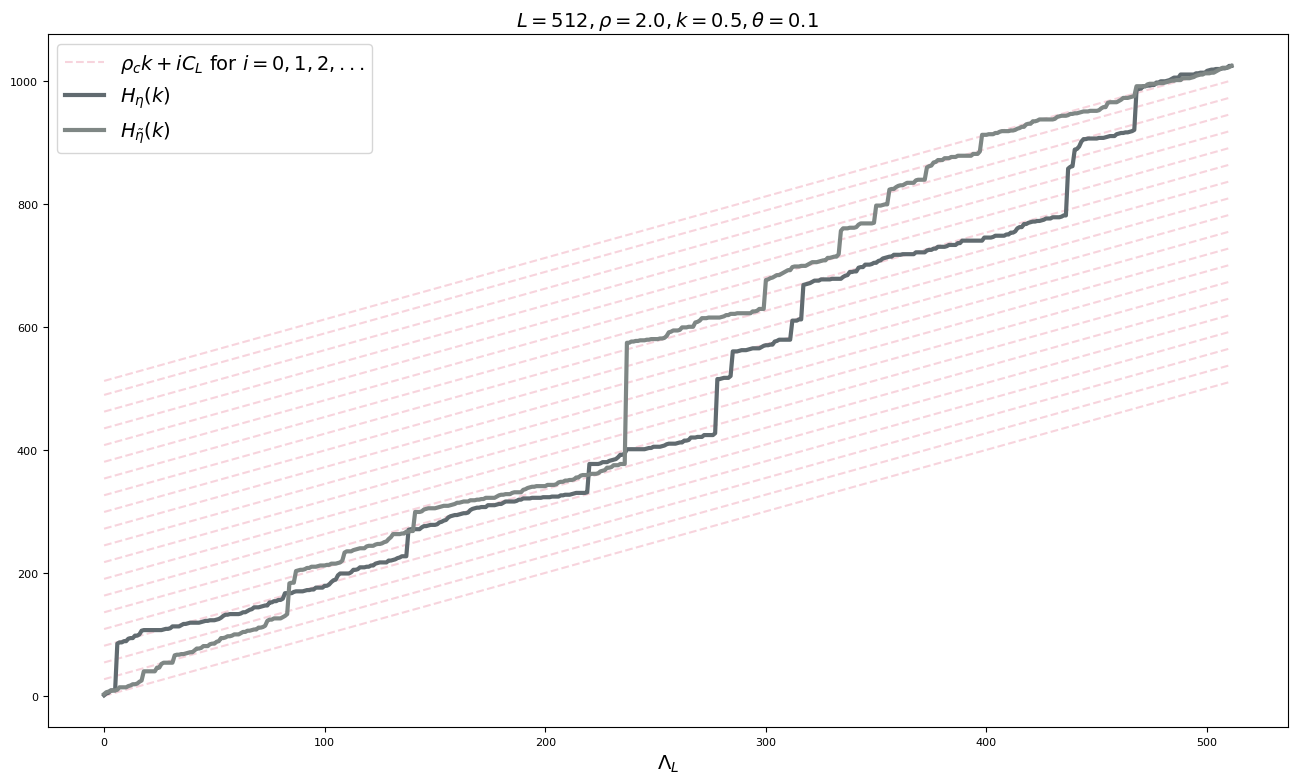

In [38]:
def graphsWithTails(axs, idx):
  left, right = axs[0,0], None #axs[1, 0]

  if(idx >= len(sims)):
    return

  sim = sims[idx]
  L, N, k, theta, rho, lattices = sim.fetch('L', 'N', 'k', 'theta', 'rho', 'lattice')
  C_L = sim.C_L()

  for ln_indx in range(int((N - 1 * L)//C_L) + 1):
    left.plot(range(L), [1 * l + ln_indx * C_L  for l in range(L)], '--', color=__cherry + '33')
  left.plot(range(L), [1 * l + N-L  for l in range(L)], '--', color=__cherry + '33', label="$\\rho_c k + iC_L$ for $i=0,1,2,...$")

  for lat_indx in [0, 3]: #range(lattices.shape[0]):
    H_eta = np.cumsum(lattices[lat_indx])

    process_name = "\\eta" if lat_indx == 0 else "\\tilde{\\eta}"
    left.plot(range(L), H_eta, 
              color=__grey_scale[(lat_indx + 2)%4],
              label = f"$H_{{{process_name}}}(k)$", linewidth=3)

  left.set_title(f'$L={L}, \\rho={rho}, k={k}, \\theta={theta}$', fontsize=14)
  left.legend(fontsize=14)
  left.set_xlabel('$\\Lambda_{L}$', fontsize=14)

  if right is None:
    return

  all_latticces = lattices.flatten()
  domain = np.linspace(0, max(all_latticces)/C_L, 1000)
  tails = np.array([ sum(all_latticces * (all_latticces > x * C_L)) / N / lattices.shape[0] for x in domain ])

  right.set_yscale('log')
  right.set_title(f'tail of $\\tilde{{\\eta}}$, $C_L={C_L}$')
  right.plot(domain, 1 - beta.cdf(domain, 1, 1), '--', color='#007700', label='beta(1, 1)-tail')
  right.plot(domain, 1 - gamma.cdf(domain, 1, 1), '--', color='#000077', label='gamma(1, 1)-tail')
  #axs[1,0].plot(domain, 10*(1 - gamma.cdf(domain, 2, 1)), '--', color='#000077', label='gamma-tail')
  #axs[1,0].plot(domain, 10*(1 - gamma.cdf(domain, 3, 1)), '--', color='#000077', label='gamma-tail')
  right.plot(domain, tails, color="red", label="$\\tilde{{\\eta}}$ tails")
  right.legend()

reloadData()
data = data[data['k'] == 0.5].sort_values(['L'])
sims = groupedSims()
#indeces = selectDataIndices('*', '*', '==0.5', '*', '*') #| selectParamIndeces('*', '*', '==-2', '*', '*')
#params = params[indeces].sort_values(['k', 'L'])

drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=graphsWithTails,
  save_settings = {"path": r"D:\OneDrive - student.uni-augsburg.de\Uni\master\Stipendium\img\cumsum.pdf"})

## (old; started refactoring, worth it?) Tail Plots 

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors_rho_cL = {}


def multipleSimTailsGroupedByk(axs, idx):

  k = [-2, 0, 0.5, 1, 1.5, 2.5][idx]#[0.5, 1.5][idx]
  data_k = data[data['k'] == k]
  sims = groupedSims(df = data_k)
  
  rho_c = 1
  domain_stepcount = 1000

  rhos = []
  domain_upper_bound = 0
  for i, sim in enumerate(sims):
    rho, lattices, theta, L = sim.fetch('rho', 'lattice', 'theta', 'L')
    rho_c_L = sim.rho_c_L()
    C_L = sim.C_L()
    domain, tails = sim.tail()
    colors_rho_cL[rho_c_L] = colors[i%len(colors)]
    domain_upper_bound = max(domain_upper_bound, domain[-1])
    rhos.append((rho, rho_c_L))

    lbl = f"$\\tilde{{\\eta}}$ tails, $C_L={C_L:.2f}, \\rho={rho}, \\rho_{{c, L}}={rho_c_L}, L={L}, m={lattices.shape[0]}$"
    lbl = f"$\\rho={rho}, L={L}, n={lattices.shape[0]}, \\theta={theta}$"
    axs[0,0].plot(domain, tails, 
    color=__theme_color_scales[int(rho//2 - 1),i%3],#colors[i%len(colors)],
    label=lbl, linewidth=3)
  
  rhos = np.array(list(set(rhos)))

  for rho, data_rho in data_k.groupby("rho"):
    params_rho_const = params_k_const[params_k_const['N']/params_k_const['L'] == rho]
    domain = np.linspace(0, domain_upper_bound, domain_stepcount)
    all_tails = []
    for i in range(params_rho_const.shape[0]):
      sim = SimulationFile(*params_rho_const.iloc[i])
      #if sim.lattices.shape[0] != 16:
      #  continue
      _, tails = sim.tail(domain_upper_bound)
      all_tails.append(tails)
    tails = np.mean(np.array(all_tails), axis=0)
    #axs[1,0].plot(domain, tails)

  if k != -2:
    for i, (rho, rho_c_L) in enumerate(rhos):
      factor = (rho - rho_c)/rho #*(0.5 * (k+2)/(k+1))**(k+2)
      factor_L = (rho - rho_c_L)/rho #*(0.5 * (k+2)/(k+1))**(k+2)
      domain = np.linspace(0, domain_upper_bound, domain_stepcount)
      y = 1 - (1 - factor) - factor * spstgamma(k+2, 1).cdf(domain)
      axs[0,0].plot(
        domain, y, '-.', 
        color=colors_rho_cL[rho_c_L],
        label=f'$\\rho_{{c, L}}/\\rho + (\\rho - \\rho_{{c, L}})/\\rho * \\Gamma({k + 2}, 1)$-tail' 
        + f'$\\rho={rho}, \\rho_{{c, L}}={rho_c_L}$')
      axs[1,0].plot(
        domain, y, '-.',
        color=colors_rho_cL[rho_c_L],
        label=f'$\\rho_{{c, L}}/\\rho + (\\rho - \\rho_{{c, L}})/\\rho * \\Gamma({k + 2}, 1)$-tail' 
        + f'$\\rho={rho}, \\rho_{{c, L}}={rho_c_L}$')

    axs[0,0].set_ylim(2 * 10**(-3), 1)
    axs[1,0].set_ylim(2 * 10**(-3), 1)
    axs[0,0].set_yscale('log')
    axs[1,0].set_yscale('log')

  if k == -2:
    print((rhos[:,0] - 1)/rhos[:,0])
    axs[0,0].hlines((rhos[:,0] - 1)/rhos[:,0], -0.1, 1.1, color=__cherry + '33', linestyle='--', label="y = 0.75 and 0.5 lines")

  axs[0,0].set_title(f'tails of $\\tilde{{\\eta}}/(\\rho - \\rho_c)/L$, $k={k}$')
  #axs[0,0].set_ylim(0.2, 0.9)
  #axs[0,0].set_xlim(0, 5)
  axs[0,0].legend()
  #axs[1,0].legend()

reloadData()
indices = (data['k'] <= 0) & (data['runtime']/data['N'] == 10000)
data = data[indices].sort_values(['k', 'L'])


drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=multipleSimTailsGroupedByk,
  save_settings = {"path": r"D:\OneDrive - student.uni-augsburg.de\Uni\master\Latex\img\single_site_cluster.pdf"})


## (old) Evaluation of Empirical $\phi_L$

In [ ]:
reloadParams()
indeces = selectParamIndeces('*', '*', '*', '*', 'T10N_SSource')
params = params[indeces]
print("T=10N")
print("\tL, N, k, theta, \t\tC_L, Phi_L, 1-1/C_L")
for i in range(len(params)):
  sim = SimulationFile(*params.iloc[i])
  #print(*params.iloc[i])
  phiL=sim.Phi_L(10 * sim.N)
  param_names = tuple(params.iloc[i][['L', 'N', 'k', 'theta']])
  print(f"\t {str(param_names)[1:-1]}\t{sim.C_L}, {phiL}, {1-1/sim.C_L}")

reloadParams()
indeces = selectParamIndeces('*', '*', '*', '*', 'T100N_SSource')
params = params[indeces]
print("T=100N")
print("\tL, N, k, theta, \t\tC_L, Phi_L, 1-1/C_L")
for i in range(len(params)):
  sim = SimulationFile(*params.iloc[i])
  #print(*params.iloc[i])
  phiL=sim.Phi_L(100 * sim.N)
  param_names = tuple(params.iloc[i][['L', 'N', 'k', 'theta']])
  print(f"\t {str(param_names)[1:-1]}\t{sim.C_L}, {phiL}, {1-1/sim.C_L}")

reloadParams()
indeces = selectParamIndeces('*', '*', '*', '*', 'T1000N_SSource')
params = params[indeces]
print("T=1000N")
print("\tL, N, k, theta, \t\tC_L, Phi_L, 1-1/C_L")
for i in range(len(params)):
  sim = SimulationFile(*params.iloc[i])
  #print(*params.iloc[i])
  phiL=sim.Phi_L(1000 * sim.N)
  param_names = tuple(params.iloc[i][['L', 'N', 'k', 'theta']])
  print(f"\t {str(param_names)[1:-1]}\t{sim.C_L}, {phiL}, {1-1/sim.C_L}")

# Write C++ Code for Continued Simulation

In [ ]:
reloadParams()
indeces = selectParamIndeces('*', '*', '>=0', '==1', 'T10000N') #('*', '*', '>=0', '==0.1', 'T10000N')
params = params[indeces]


def float2Str(flt):
    _flt = str(flt)
    _flt = _flt.rstrip('0').rstrip('.') if '.' in _flt else _flt
    return _flt

print(len(params))

for i in range(len(params)):
  sim = SimulationFile(*params.iloc[i])
  if sim.lattices.shape[0] != 16:
    continue
  template = f"""
    SimulationParams::Init = Field::Initialisation::FromSource;
    SimulationParams::LatticeSize = {int(params.iloc[i]['L'])};
    SimulationParams::ParticleCount = {int(params.iloc[i]['N'])};
    SimulationParams::Degree = {float2Str(params.iloc[i]['k'])};
    SimulationParams::Runtime = 1000 * SimulationParams::ParticleCount;
    SimulationParams::Theta = {float2Str(params.iloc[i]['theta'])};
    runFromSource();
  """
  print(template)

# Other

*$k=0, \theta=1$*

In [ ]:
from scipy.special import comb

def binary_entropy(p):
  p = np.clip(p, 1e-10, 1 - 1e-10)  # Avoid log(0) errors
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def a0(L, rho):
  _H = binary_entropy(1 / (rho + 1))
  exponent = ((rho + 1) * L) * (_H - 1) - _H
  return np.power(2, exponent)

# Case 1: `i` is an array, `rho` is a scalar
def a_i_array(i, L, rho):
    N = int(rho * L)
    S = np.arange(N)  # Shape (N,)
    _H = binary_entropy(1 / (rho + 1 - S / L))  # Shape (N,)

    i = np.atleast_1d(i)  # Convert to array if scalar
    term1 = np.power(1 / L, i)  # Shape (len(i),)
    term2 = comb(i[:, None] + S - 1, i[:, None] - 1, exact=False)  # Shape (len(i), N)
    exponent = ((rho + 1) * L - S - i[:, None]) * (_H - 1) - _H  # Shape (len(i), N)
    term3 = np.power(2, exponent)  # Shape (len(i), N)

    return term1 * np.sum(term2 * term3, axis=1)  # Shape (len(i),)

# Case 2: `rho` is an array, `i` is a scalar
def a_rho_array(i, L, rho):
  rho = np.atleast_1d(rho)  # Convert `rho` to array if scalar
  N = (rho * L).astype(int)  # Shape matches `rho`
  max_N = np.max(N)
  S = np.arange(max_N + 1)  # Shape (max_N,)
  
  valid_S_mask = S[None, :] < N[:, None]  # Shape (len(rho), max_N)
  _H = binary_entropy(1 / (rho[:, None] + 1 - S[None, :] / L))  # Shape (len(rho), max_N)
  
  term1 = np.power(1 / L, i)  # Scalar
  term2 = comb(i + S[None, :] - 1, i - 1, exact=False) * valid_S_mask  # Shape (len(rho), max_N)
  exponent = ((rho[:, None] + 1) * L - S[None, :] - i) * (_H - 1) - _H  # Shape (len(rho), max_N)
  term3 = np.power(2, exponent) * valid_S_mask  # Shape (len(rho), max_N)
  
  return term1 * np.sum(term2 * term3, axis=1)  # Shape (len(rho),)


def graphsZln(axs, idx):
  axs = axs[0, 0]
  if idx == 0:
    L=1000
    rho = 2

    I = np.arange(1,L)
    A = [a0(L, rho)] + a_i_array(I, L, rho)
    axs.set_title(f"$a_i$ with $L={1000}, rho={rho}$")
    axs.plot(I, A)
    axs.set_yscale('log')

  if idx == 1:
    # want Z_{L-1, N-n}/Z_{L, N} for n = 1, 2, 3, 4, 5
    axs.set_title("$Z_{L-1, N-n}/Z_{L, N}$ for $n \in \{1, ..., N\}$")
    for L in [1000, 2000, 3000, 4000]: 
      rho = 2
      N = int(rho * L)
      nn = np.arange(1, N+1)
      Z_LN = a0(L, rho) + a_i_array(1, L, rho)
      rhoL1Nn = (N-nn)/(L-1)

      debug = a_rho_array(1, L-1, rhoL1Nn)
      nans = np.where(np.isnan(debug))[0]
      maxind = np.min(nans) - 1 if len(nans) > 0 else len(debug)

      Z_LNn = a0(L-1, rhoL1Nn) + a_rho_array(1, L-1, rhoL1Nn)
      Z_LN, Z_LNn, nn = Z_LN[:maxind], Z_LNn[:maxind], nn[:maxind]
      q = Z_LNn/Z_LN
      axs.plot(nn, Z_LNn/Z_LN, label=f"$L={L}, N={N}$")
      axs.vlines(nn[np.argmax(q)], 0, 20, color='gray', linestyle='--', label=f"$argmax(q)={nn[np.argmax(q)]}$")
    axs.legend()
  
  if idx == 2:
    # want Z_{L-1, N-n}/Z_{L, N} for n = 1, 2, 3, 4, 5
    axs.set_title("$Z_{L-1, N-n}/Z_{L, N}$ for $n \in \{1, ..., N\}$")
    axs.set_ylim(0, 2)
    for L in [1000, 2000, 3000, 4000]: 
      rho = 2
      N = int(rho * L)
      nn = np.arange(1, N+1)
      Z_LN = a0(L, rho) + a_i_array(1, L, rho)
      rhoL1Nn = (N-nn)/(L-1)
      Z_LNn = a0(L-1, rhoL1Nn) + a_rho_array(1, L-1, rhoL1Nn)
      q = Z_LNn/Z_LN
      axs.plot(nn, Z_LNn/Z_LN, label=f"$L={L}$")
      #axs.vlines(nn[np.argmax(q)], 0, 2, color='gray', linestyle='--', label=f"$argmax(q)={nn[np.argmax(q)]}$")
    axs.legend()


drawGraphs(
  cols=2, rows=2,
  col_weights=[1], row_weights=[1],
  graph_factory=graphsZln)

In [ ]:
def gross1(n, l, k):
  log_result = (l*k) * np.log(n) + np.sum(np.log(np.arange(1, l) + k))
  return np.exp(log_result)

def blank1(n, l, k):
  log_result = (l * (k + 1)) * np.log(n) + l * np.log(sp.special.gamma(k + 1)) - np.log(sp.special.gamma(l * (k + 1)))
  return np.exp(log_result)

def array_hash(arr):
    return hash(arr.tobytes())

def simplex_sum_prod(n, l, k):
  todo = [np.zeros(l)]
  done = set()
  sum_prod = 0
  while len(todo) > 0:
    p = todo.pop()

    p_hash = array_hash(p)
    if p_hash in done:
      continue

    done.add(p_hash)

    if np.sum(p) < n:
      for i in range(l):
        p_ = p.copy()
        p_[i] += 1
        todo.append(p_)
    elif np.sum(p) == n:
      sum_prod += np.prod(np.power(p+1, k))
  return sum_prod

def simplex_sum_prod_approx(n, l, k):
  return sp.special.binom(n + l - 1, n) * (n/l + 1)**(l*k)


for n in range(1, 10):
  for l in range(1, 10):
      print(f"n={n}, l={l}: {simplex_sum_prod(n, l, 1)}, {blank1(n, l, 1)}, {gross1(n, l, 1)}")


In [ ]:
def logGamma(n):
  return n*np.log(n) - n + 0.5*np.log(2*np.pi*n)

def ln_b(l, n, k, L, rho):
  t = 1
  log_result = l * np.log(t) + logGamma(l+1) + l * (k+1) * np.log(n) \
    + l * logGamma(k+1) - logGamma(l * (k+1)) \
    + 0.5 * (np.log(1 + rho - n/L) - np.log(2 * np.pi * L * (rho - n/L))) \
    + L * ((1 + rho - n/L) * np.log((1 + rho - n/L)/2) - (rho - n/L) * np.log(rho - n/L))
  return log_result

ks = [1, 2, 3, 4, 5, 6, 7]

def b_ln(axs, idx):
  if(idx >= len(ks)):
    return

  k = ks[idx]
  rho = 2
  L = np.power(2, 8)
  N = rho * L
  l_domain = np.arange(1, L)
  y = ln_b(l_domain, N-L, k, L, rho)
  exp_y = np.exp(y)

  axs[0,0].plot(l_domain, y, label="$\ln(b_{l,n})$")
  axs[1,0].plot(l_domain, exp_y, label="$b_{l,n}$")
  axs[0,0].legend()
  axs[1,0].legend()
  axs[0,0].set_title(f"$k={k}, \\rho={rho}, L={L}, N={N}$")


drawGraphs(
  cols=2, rows=3,
  col_weights=[1,1], row_weights=[1],
  graph_factory=b_ln)

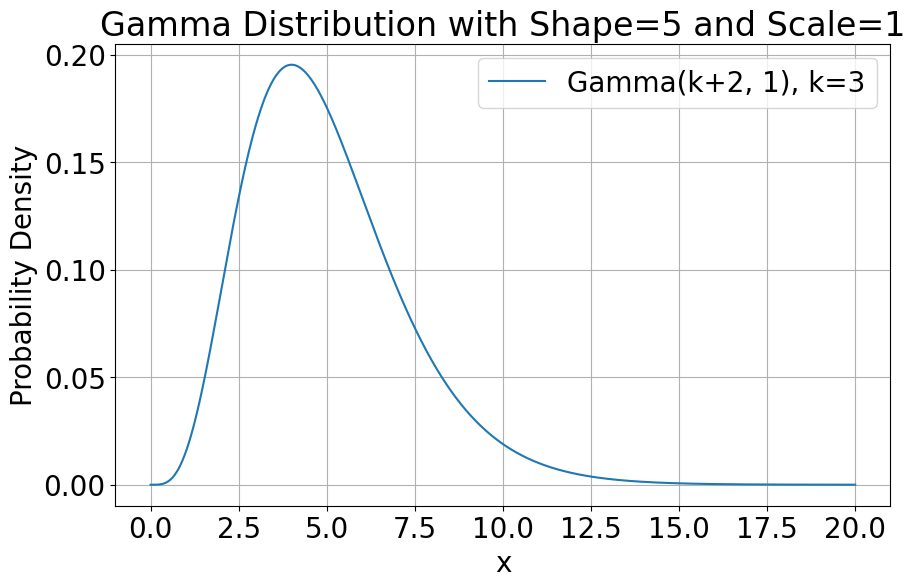

In [85]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the shape parameter k
k = 3  # You can change this value as needed

# Define x-axis values
x = np.linspace(0, 20, 1000)

# Calculate pdf of Gamma distribution
y = stats.gamma.pdf(x, a=k+2, scale=1)

# Create plot of Gamma distribution
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Gamma(k+2, 1), k={k}')
plt.title(f'Gamma Distribution with Shape={k+2} and Scale=1')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## Convert Data Files to Csv

In [35]:
reloadParams()
data = params.copy()
data["gamma"] = [1 for row in params.itertuples(index=False)]
data["rho"] = params["N"]/params["L"]
data["jumps"] = [SimulationFile(*row).jumps for row in params.itertuples(index=False)]
data["initial_conditions"] = [SimulationFile(*row).initial_conditions for row in params.itertuples(index=False)]
data["runtime"] = [SimulationFile(*row).runtime for row in params.itertuples(index=False)]
data["sim"] = [SimulationFile(*row).lattices for row in params.itertuples(index=False)]
data = data.explode(['sim', 'jumps', 'initial_conditions'], ignore_index=True)
data["sim"] = data["sim"].apply(lambda x: ','.join(map(str, x)))
data.to_csv(r"D:\OneDrive - student.uni-augsburg.de\Uni\master\simulation output\sims.csv", index=False)
#print(np.array(data["sim"].iloc[1])[6])

In [36]:
data = pd.read_csv(r"D:\OneDrive - student.uni-augsburg.de\Uni\master\simulation output\sims.csv")
data['sim'] = data['sim'].apply(lambda x: np.array([int(i) for i in x.split(',')]))
data

,L,N,k,theta,extra_info,gamma,rho,jumps,initial_conditions,runtime,sim
0,1024.0,2048.0,-2.0,1.0,T10000N,1,2.0,-1,random uniform,20480000,"[0, 0, 3, 2, 3, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ..."
1,1024.0,2048.0,-2.0,1.0,T10000N,1,2.0,-1,random uniform,20480000,"[0, 0, 0, 0, 0, 2, 2, 0, 0, 5, 2, 0, 4, 0, 0, ..."
2,1024.0,2048.0,-2.0,1.0,T10000N,1,2.0,-1,random uniform,20480000,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 3, 0, 1, 1, 3, ..."
3,1024.0,2048.0,-2.0,1.0,T10000N,1,2.0,-1,random uniform,20480000,"[0, 0, 3, 2, 6, 5, 1, 0, 3, 0, 0, 0, 2, 0, 3, ..."
4,1024.0,2048.0,-2.0,1.0,T10000N,1,2.0,-1,random uniform,20480000,"[0, 0, 0, 1, 7, 3, 0, 2, 1, 1, 0, 2, 0, 1, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
843,512.0,2048.0,1.0,1.0,T1000N_SSource,1,4.0,2837441073,from source,2048000,"[2, 0, 0, 3, 21, 1, 1, 0, 1, 1, 1, 0, 5, 0, 1,..."
844,512.0,2048.0,1.0,1.0,T1000N_SSource,1,4.0,3783124372,from source,2048000,"[0, 20, 1, 0, 0, 0, 0, 2, 25, 0, 2, 0, 0, 1, 0..."
845,512.0,2048.0,1.0,1.0,T1000N_SSource,1,4.0,3783198708,from source,2048000,"[2, 1, 0, 1, 0, 1, 34, 2, 0, 2, 0, 3, 0, 0, 0,..."
846,512.0,2048.0,1.0,1.0,T1000N_SSource,1,4.0,3783134273,from source,2048000,"[17, 0, 0, 0, 0, 0, 7, 0, 10, 1, 0, 1, 33, 0, ..."


# Included in Master

## Cum Sum

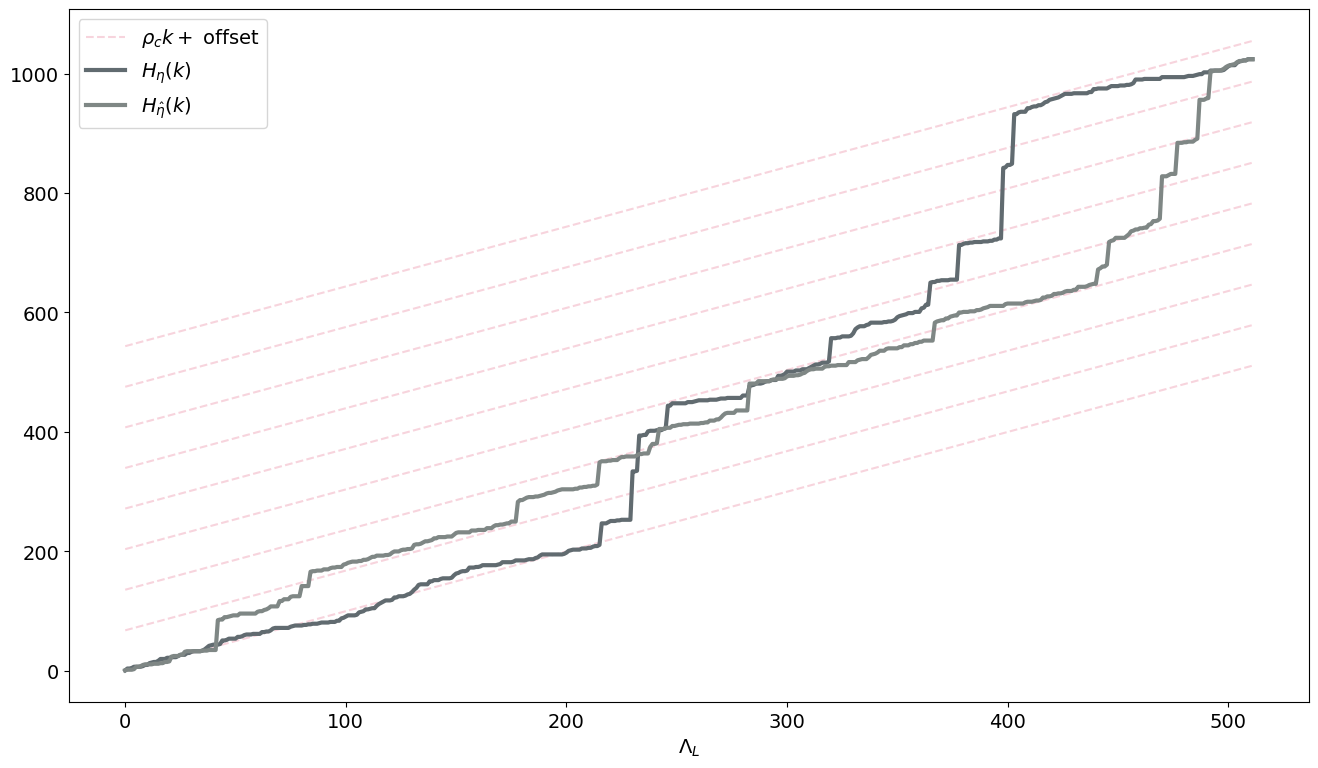

In [129]:
def graphsWithTails(axs, idx):
  axs = axs[0,0]

  if(idx >= len(sims)):
    return

  sim = sims[idx]
  L, N, k, theta, rho, lattices = sim.fetch('L', 'N', 'k', 'theta', 'rho', 'lattice')
  C_L = sim.C_L()

  mean = C_L* (k + 2) * (rho - 1)
  for ln_indx in range(int((N - 1 * L)//mean) + 1):
    axs.plot(range(L), [1 * l + ln_indx * mean  for l in range(L)], '--', color=__cherry + '33')
  ln_indx +=1
  axs.plot(range(L), [1 * l + ln_indx * mean  for l in range(L)], '--', color=__cherry + '33', label="$\\rho_c k +$ offset")

  for lat_indx in [0, 3]:
    H_eta = np.cumsum(lattices[lat_indx])

    process_name = "\\eta" if lat_indx == 0 else "\\hat{\\eta}"
    axs.plot(range(L), H_eta, 
              color=__grey_scale[(lat_indx + 2)%4],
              label = f"$H_{{{process_name}}}(k)$", linewidth=3)

  axs.legend(fontsize=14)
  axs.set_xlabel('$\\Lambda_{L}$')

reloadData()
data = data[data['k'] == 0.5].sort_values(['k', 'L'])
sims = groupedSims()

drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=graphsWithTails,
  save_settings = {"path": r"..\Latex\img\cumsum.pdf"},
  font_size='large')

## Tail k < 0

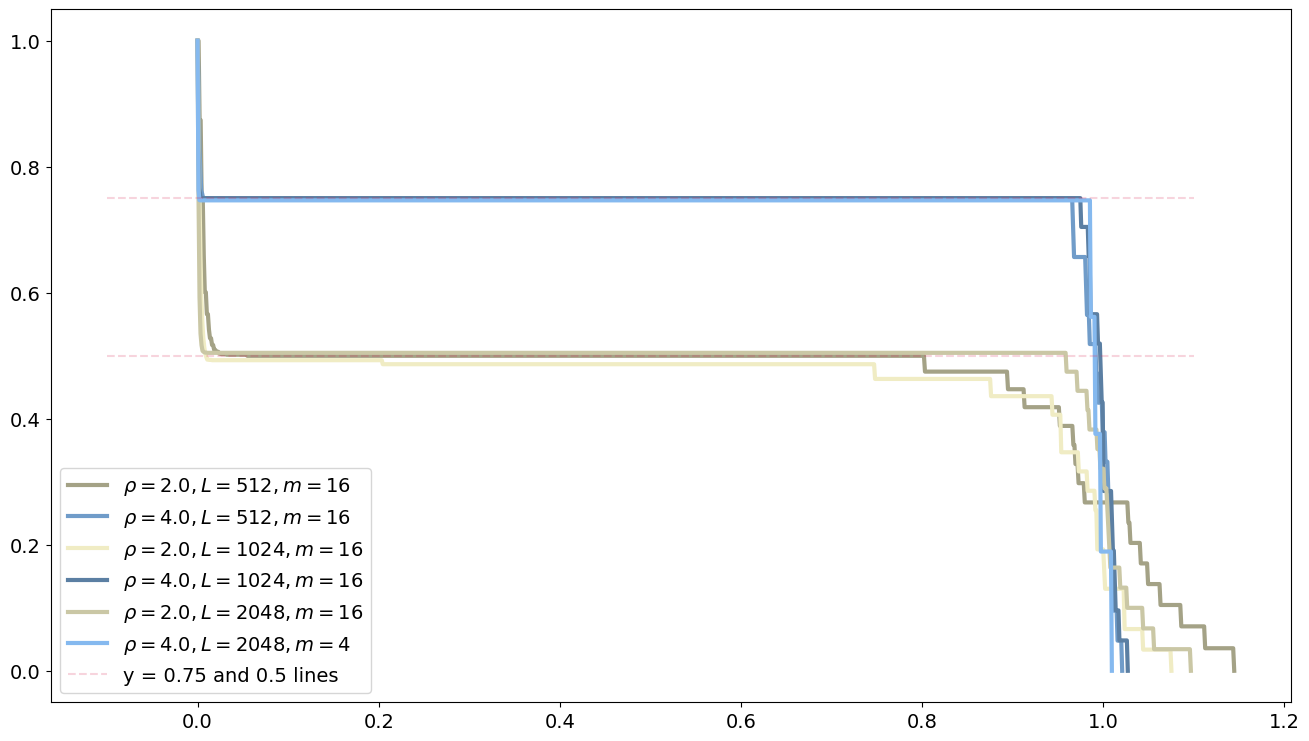

In [131]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors_rho_cL = {}

def _tail(sim, domain_upper_bound = None):
  lattices = np.array(sim.other['lattice'])
  print(lattices)
  N = sim.params['N']
  C_L = sim.C_L()
  etas_fl = np.array(lattices).flatten()
  print(lattices.shape)
  print(etas_fl.shape)
  if domain_upper_bound is None:
    domain_upper_bound = np.max(etas_fl)/C_L
  domain = np.linspace(0, domain_upper_bound, 1000)
  _tail = ((etas_fl > C_L * domain.reshape(-1, 1)) @ etas_fl) / (N * lattices.shape[0])
  return domain, _tail


def multipleSimTailsGroupedByk(axs, idx):
  axs = axs[0,0]
  k = -2
  rho_c = 1
  domain_stepcount = 1000
  sims = groupedSims()
  
  domain_upper_bound = 0
  for i, sim in enumerate(sims):
    domain, tails = sim.tail()
    C_L = sim.C_L()
    rho, L, lattices = sim.fetch('rho', 'L', 'lattice' )

    domain_upper_bound = max(domain_upper_bound, domain[-1])

    lbl = f"$\\rho={rho}, L={L}, m={lattices.shape[0]}$"
    axs.plot(domain, tails, 
    color=__theme_color_scales[int(rho//2 - 1),i%3],
    label=lbl, linewidth=3)
  
  rhos = []
  data_rho = data.groupby('rho')
  for group, df in data_rho:
    rhos.append(group)
    sims = groupedSims(df = df)
    domain = np.linspace(0, domain_upper_bound, domain_stepcount)
    all_tails = []
    for sim in sims:
      _, tails = sim.tail(domain_upper_bound)
      all_tails.append(tails)
    tails = np.mean(np.array(all_tails), axis=0)

  rhos = np.array(rhos)
  axs.hlines((rhos - 1)/rhos, -0.1, 1.1, color=__cherry + '33', linestyle='--', label="y = 0.75 and 0.5 lines")
  axs.legend()


reloadData()
indices = (data['k'] == -2) & (data['runtime']/data['N'] == 10000)
data = data[indices].sort_values(['k', 'L', 'rho'])


drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=multipleSimTailsGroupedByk,
  save_settings = {"path": r"..\Latex\img\single_site_cluster.pdf"},
  font_size='large')


## Tail k > -1

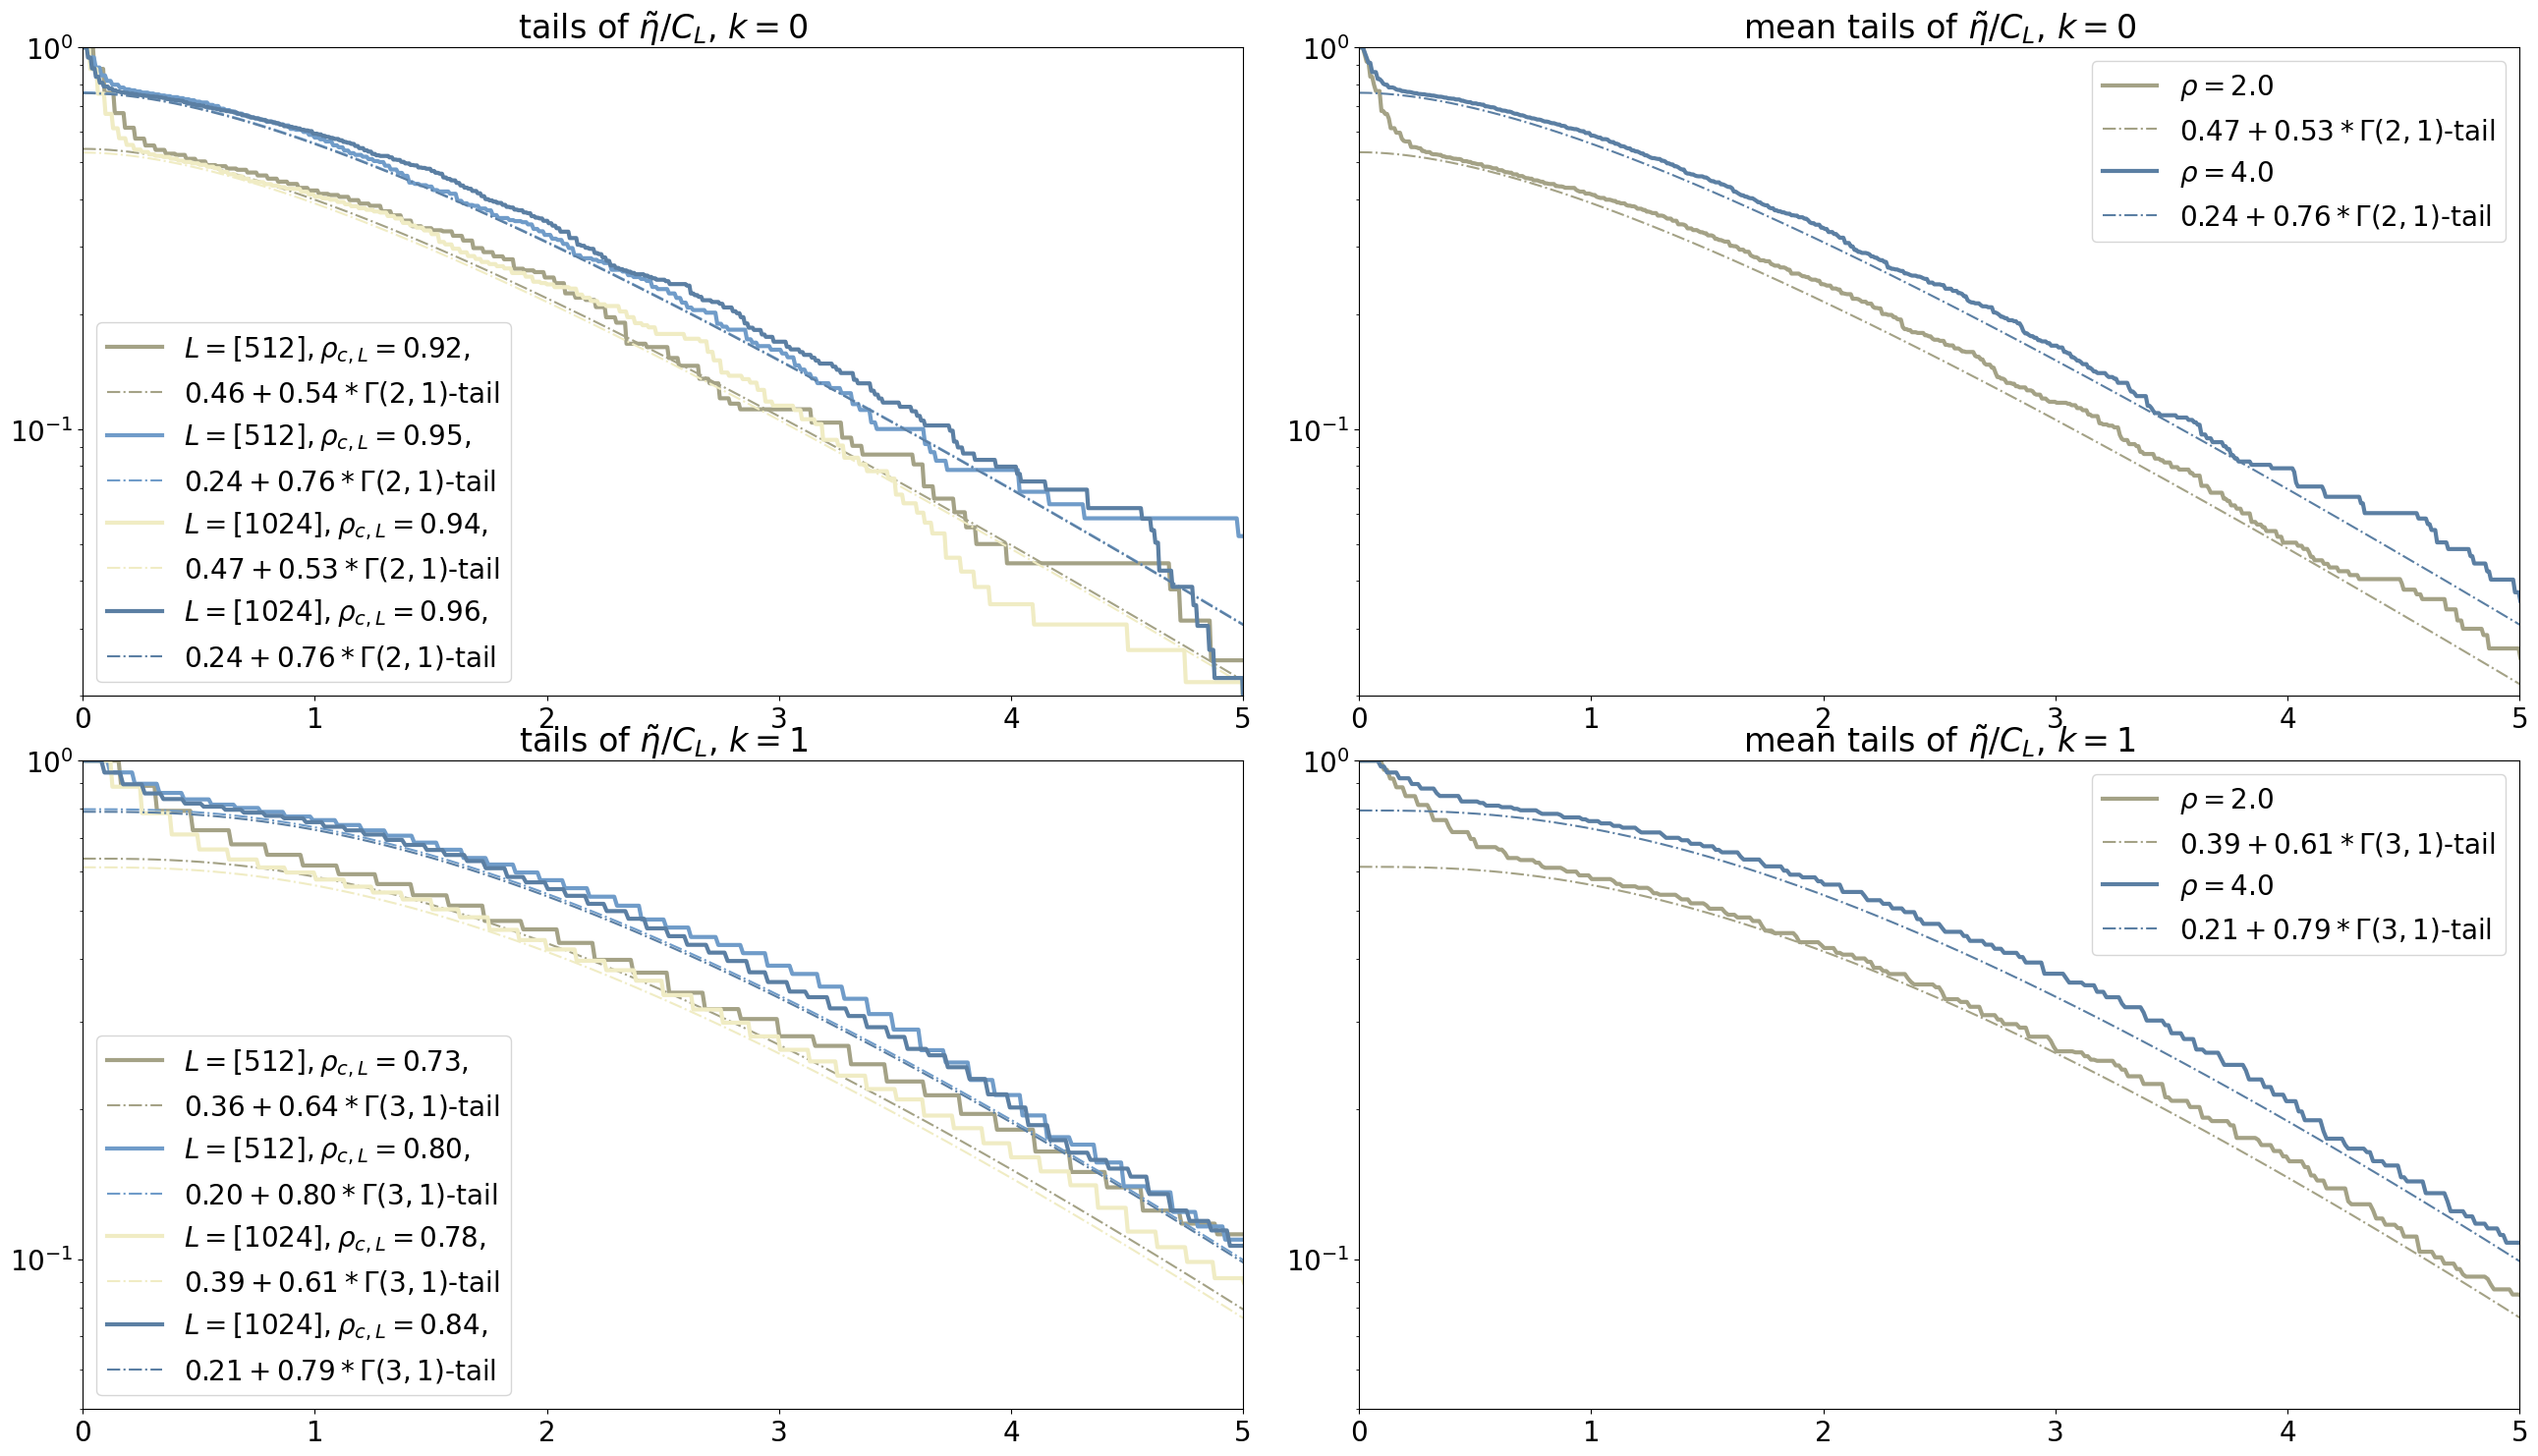

In [135]:
def label_sim(sim):
  L = sim.fetch('L')
  rho_c_L = sim.rho_c_L()
  return \
    f"$L={L}, $" + \
    f"$\\rho_{{c, L}}={rho_c_L:.2f}, $"
  #f"$C_L={sim.C_L:.2f}, " + \

def label_gamma(factor_L, k):
  return f'${1-factor_L:.2f} + {factor_L:.2f} * \\Gamma({k + 2}, 1)$-tail'


def plot_gammaesque_tail(ax, domain, rho, rho_c_L, k, color):
  factor_L = (rho - rho_c_L)/rho
  y = 1 - (1 - factor_L) - factor_L * spstgamma(k+2, 1).cdf(domain)
  ax.plot(
    domain, y, '-.', 
    color=color, #__cherry + '33',
    label=label_gamma(factor_L, k))


def multipleSimTailsGroupedByk(axs, idx):
  k = [0,1][idx]#[0.5, 1.5][idx]
  #k_const_indices = selectParamIndeces('*', '*', f'=={k}', '*', '*')

  data_k = data[data['k'] == k]
  sims = groupedSims(df = data_k)
  #data["sim"] = [SimulationFile(*row) for row in data.itertuples(index=False)]
  #data["rho"] = data["N"]/data["L"]
  
  rho_c = 1
  domain_upper_bound = 0

  # plot all simulations
  # + gamma tail
  for i, sim in enumerate(sims[:4]):
    rho = sim.fetch('rho')[0]
    rho_c_L = sim.rho_c_L()
    color = __theme_color_scales[int(rho//2 - 1),i%3]
    domain, tails = sim.tail()
    axs[0,0].plot(domain, tails, color=color, label=label_sim(sim), linewidth=3)

    domain_upper_bound = max(domain_upper_bound, domain[-1])

    plot_gammaesque_tail(axs[0,0], domain, rho, rho_c_L, k, color)

  domain_stepcount = 1000

  # plot mean of all simulations with same rho
  # + gamma tails
  for rho, data_rho in data_k.groupby("rho"):
    sims = groupedSims(df = data_rho)
    color = __theme_color_scales[int(rho//2 - 1), 0]

    domain = np.linspace(0, domain_upper_bound, domain_stepcount)
    tails = [sim.tail(domain_upper_bound)[1] for sim in sims]
    mean_tails = np.mean(np.array(tails), axis=0)

    axs[1,0].plot(domain, mean_tails, label=f"$\\rho={rho}$", color=color, linewidth=3)

    rho_c_Ls = np.array([sim.rho_c_L() for sim in sims])
    plot_gammaesque_tail(axs[1,0], domain, rho, np.mean(rho_c_Ls), k, color)


  axs[0,0].set_yscale('log')
  axs[1,0].set_yscale('log')

  if idx == 0:
    axs[0,0].set_ylim(2 * 10**(-2), 1)
    axs[1,0].set_ylim(2 * 10**(-2), 1)
  if idx == 1:
    axs[0,0].set_ylim(1/2 * 10**(-1), 1)
    axs[1,0].set_ylim(1/2 * 10**(-1), 1)
  axs[0,0].set_xlim(0, 5)
  axs[1,0].set_xlim(0, 5)

  axs[0,0].set_title(f'tails of $\\tilde{{\\eta}}/C_L$, $k={k}$')
  axs[1,0].set_title(f'mean tails of $\\tilde{{\\eta}}/C_L$, $k={k}$')
  axs[0,0].legend()
  axs[1,0].legend()


#indices = selectDataIndices('*', '*', '>=0', '==1', 'T10000N')
reloadData()
indices = (data['k'] >= 0) & (data['theta'] == 1) & (data['runtime']/data['N'] == 10000)
data = data[indices].sort_values(['k', 'L'])


drawGraphs(
  cols=1, rows=2,
  col_weights=[1,1], row_weights=[1],
  graph_factory=multipleSimTailsGroupedByk,
  save_settings = {"path": r"..\Latex\img\clusters.pdf"},
  font_size='huge')

#yellow rho = 2 blue rho = 4

## Unordered Tails Conditioned on Clusters

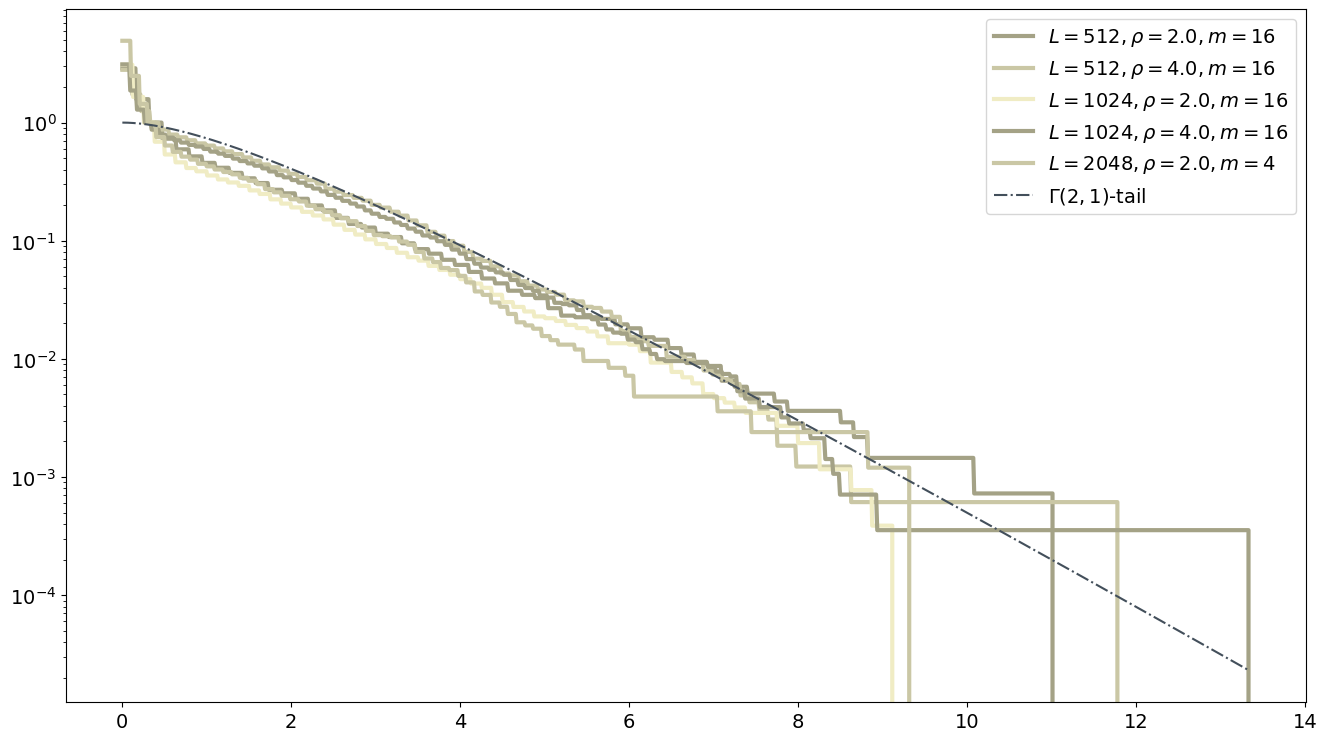

In [139]:
def label_sim(sim):
  L, rho, lattices = sim.fetch('L', 'rho', 'lattice')
  return \
    f"$L={L}, $" + \
    f"$\\rho={rho}, $" + \
    f"$m={lattices.shape[0]}$"
  #f"$C_L={sim.C_L:.2f}, " + \

def label_gamma(k):
  return f'$\\Gamma({k + 1}, 1)$-tail'


def plot_gamma_tail(ax, domain, k, color):
  y = 1 - spstgamma(k+1, 1).cdf(domain)
  ax.plot(
    domain, y, '-.', 
    color=color, #__cherry + '33',
    label=label_gamma(k))


def multipleSimTailsGroupedByk(axs, idx):
  k = [1][idx]#[0.5, 1.5][idx]

  data_k = data[data['k'] == k]
  sims = groupedSims(df = data_k)
  
  
  rho_c = 1
  domain_upper_bound = 0

  # plot all simulations
  # + gamma tail
  for i, sim in enumerate(sims):
    color = __theme_color_scales[0,i%3] #__grey_scale[i%3]
    domain, tails = sim.unordered_tail()
    axs[0,0].plot(domain, tails, color=color, label=label_sim(sim), linewidth=3)

    domain_upper_bound = max(domain_upper_bound, domain[-1])

  domain_stepcount = 1000
  domain = np.linspace(0, domain_upper_bound, domain_stepcount)
  plot_gamma_tail(axs[0,0], domain, k, __grey_scale[3])


  axs[0,0].set_yscale('log')
  axs[0,0].legend()


reloadData()
indices = (data['k'] == 1) & (data['theta'] == 1) & (data['runtime']/data['N'] == 10000)
data = data[indices].sort_values(['k', 'L'])



drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=multipleSimTailsGroupedByk,
  #save_settings = {"path": r"..\Latex\img\unordered_tail.pdf"},
  font_size='large')


## $R_L$, $R$

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_49892\2131949293.py:35: RuntimeWarning: overflow encountered in power
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * w(L, theta, k, n), axis=1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_49892\2131949293.py:35: RuntimeWarning: overflow encountered in multiply
  return np.sum(n * np.power(phi[:, np.newaxis], n-1) * w(L, theta, k, n), axis=1)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_49892\2131949293.py:27: RuntimeWarning: overflow encountered in power
  return np.sum(np.power(phi[:, np.newaxis], n) * w(L, theta, k, n), axis=1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_49892\2131949293.py:42: RuntimeWarning: invalid value encountered in divide
  return phi * dz_dphi(L, theta, k, phi) / z(L, theta, k, phi

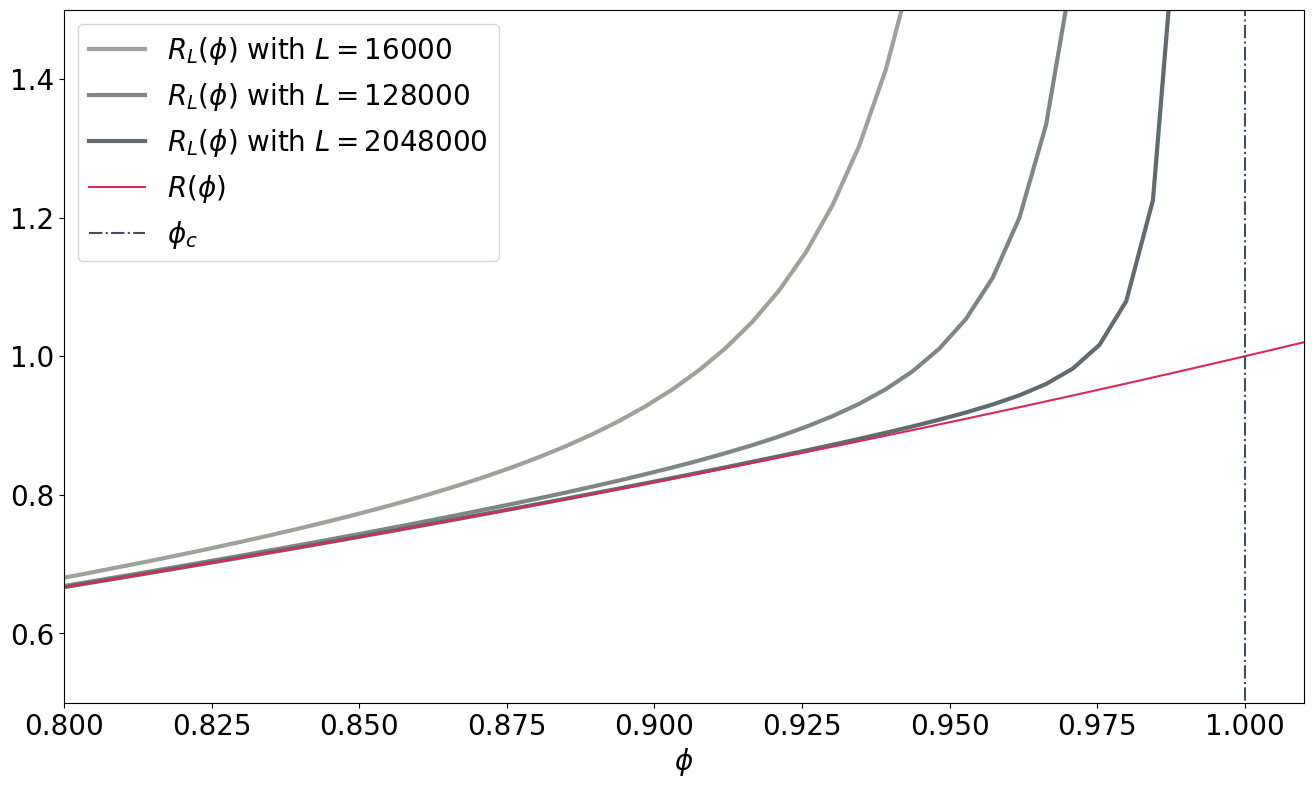

In [ ]:
ks = [ 1] #
thetas = [1]
ksXthetas = list(product(ks, thetas))
Ls = [16000, 16000*8, 16000*8*16]

def graphRL(axs, idx):
  #axl = axs[1, 0]
  axs = axs[0,0]
  (k, theta) = ksXthetas[idx]
  x_min = 0.8#{-2: 0.8, -1: 0.8, 1: 0.8}[k]
  phi_domain = np.linspace(0.6, 1.5, 200)
  rho_domain = np.linspace(0, 2, 100)
  for i, L in enumerate(Ls):
    #axs.set_title(f"$k={k}, \\theta={theta}$")
    #axl.set_title(f"$k={k}, \\theta={theta}$")
    R_eval = R(L, theta, k, phi_domain)
    axs.plot(
      phi_domain,
      R_eval,
      color = __grey_scale[i],
      label=f"$R_L(\\phi)$ with $L={L}$",
      linewidth=3)
    #axl.plot(
    #  R_eval,#rho_domain,
    #  phi_domain,#Phi(L, rho_domain, theta, k),
    #  color = __grey_scale[i],
    #  label=f"$\Phi_L(\\rho)$ with $L={L}$", 
    #  linewidth=3)
    #print(R_eval[::-1])

  _R_phi = _R(phi_domain) #[_R(phi) for phi in phi_domain]
  _Phi_rho = _Phi(rho_domain) #[_R(phi) for phi in phi_domain]
  axs.plot(phi_domain, _R_phi, color=__cherry, label="$R(\phi)$", linestyle='-')
  #axl.plot(rho_domain, _Phi_rho, color=__cherry, label="$\\Phi(\\rho)$", linestyle='-')
  axs.set_xlim(x_min, 1 + (1 - x_min)*0.05)
  axs.set_ylim(0.5, 1.5)
  #axl.set_xlim(0.5, 1.5)
  #axl.set_ylim(0.5, 1.05)
  axs.vlines(1, 0, 200, color=__grey_scale[3], linestyle="-.", label="$\\phi_c$")
  #axl.vlines(1, 0, 200, color=__grey_scale[3], linestyle="-.", label="$\\rho_c$")
  axs.legend()
  #axl.legend()
  axs.set_xlabel('$\\phi$')
  #axl.set_xlabel('$\\rho$')

drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=graphRL, 
  save_settings={"path": r"..\Latex\img\R_L.pdf"},
  font_size='huge')


## (not included) Distribution Comparison $\eta, \tilde{\eta}$

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12864\1507020937.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  params = params[indices].sort_values(['L'])


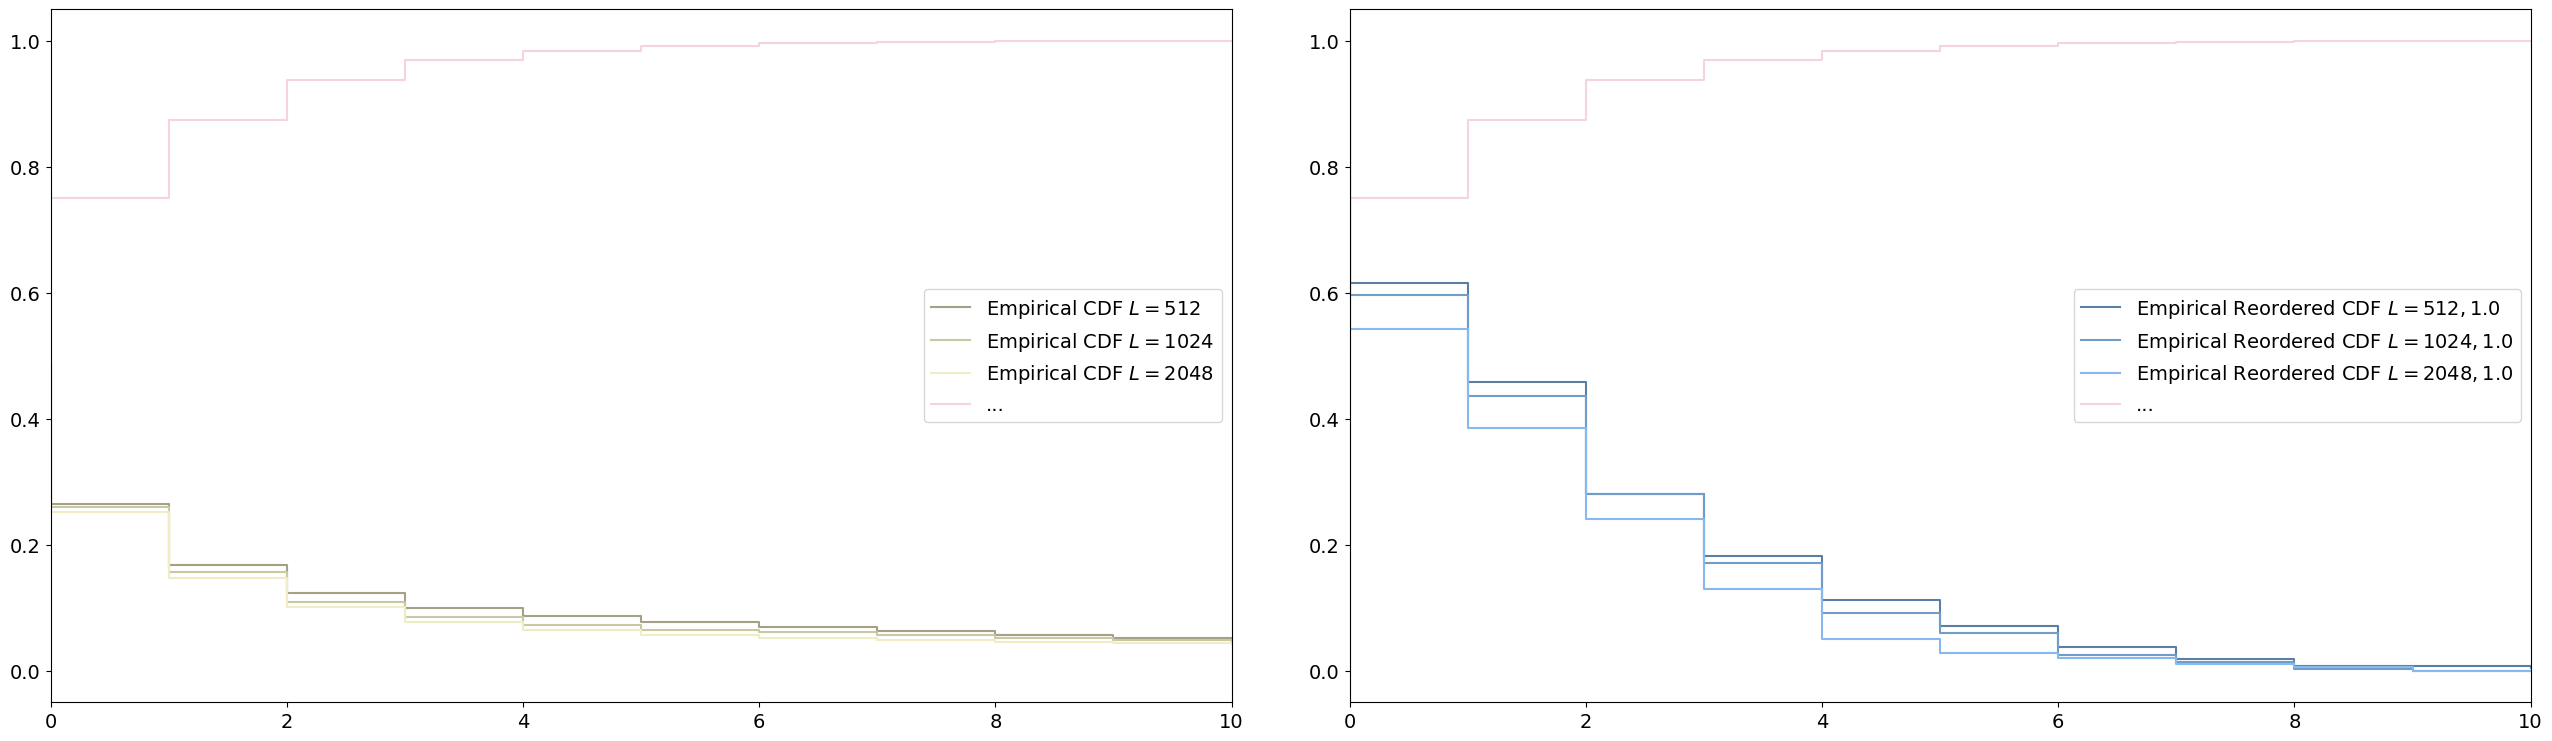

In [ ]:
reloadParams()
indices = selectParamIndeces('*', '*', '==1', '==1', 'T10000N')
params["rho"] = params["N"]/params["L"]
params = params[params["rho"] == 2]
params = params[indices].sort_values(['L'])

def graphDistributionComparison(axs, idx):
  axs = axs[0,0]
  sims = [ SimulationFile(*param[:-1]) for param in params.itertuples(index=False)]

  for i, sim in enumerate(sims):
    max_particles = np.max(sim.lattices)
    
    domain, emp_cdf = sim.empirical_distribution(max_particles)
    _, reordered_cdf = sim.empirical_distribution_reordered(max_particles)
    if idx == 0:
      axs.step(
        domain, 1-emp_cdf,
        label=f"Empirical CDF $L={sim.L}$", color = __theme_color_scales[0,i])
    if idx == 1:
      axs.step(
        domain, 1-reordered_cdf,
        label=f"Empirical Reordered CDF $L={sim.L}, {sim.k}$", color = __theme_color_scales[1,i])

  
  nu = np.cumsum(_w(np.arange(max_particles + 1)))
  #nu[domain <= 1] = 0.5
  axs.step(
    np.arange(max_particles + 1), nu,
    label=f"...", color = __cherry + '33')
  
  #axs.set_yscale('log')
  #axs.set_yticks([0, 0.5, 1])
  axs.set_xlim(0, 10)
  axs.legend()

drawGraphs(
  cols=2, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=graphDistributionComparison, 
  #save_settings={"path": r".\Latex\img\R_L.pdf"},
  font_size='large')

## Parameter discussion

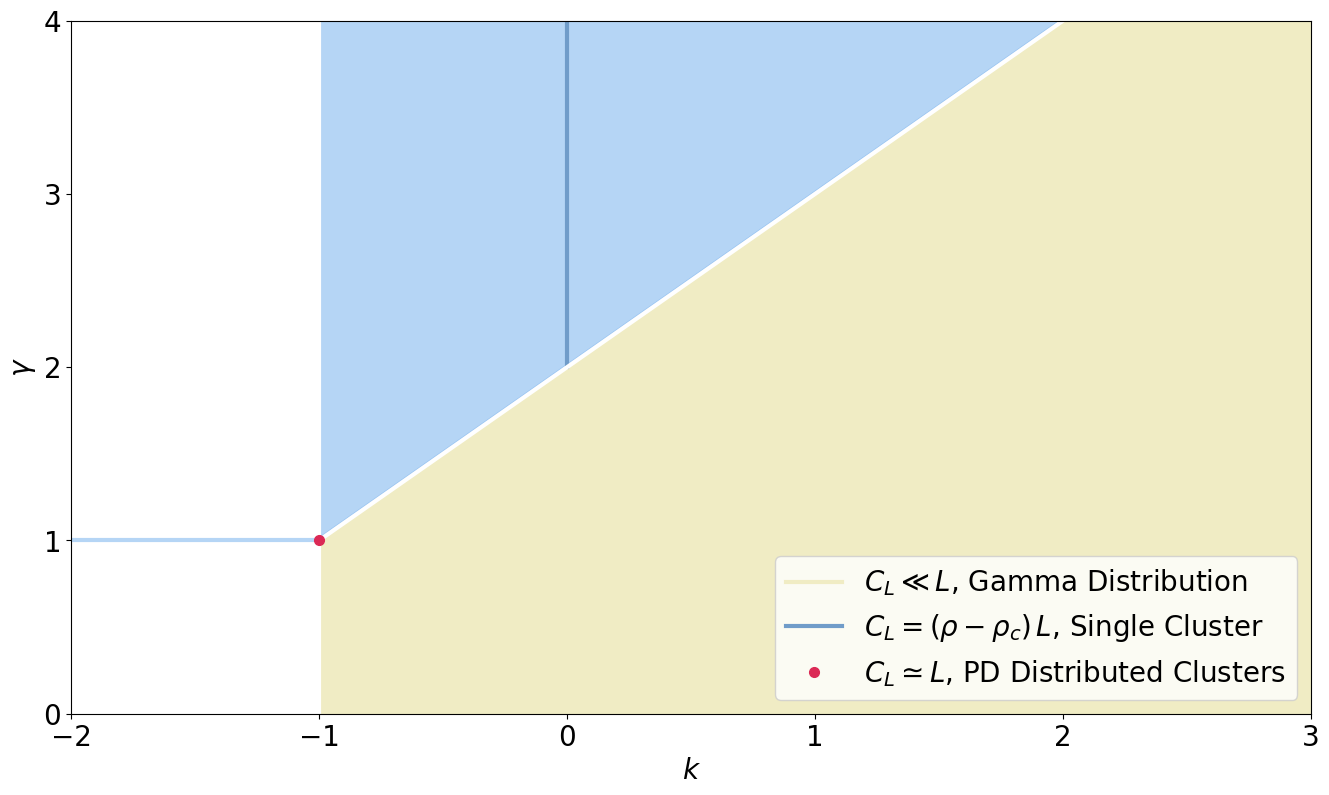

In [143]:
def kgamma(axs, idx):
  axs = axs[0,0]
  axs.set_xlabel('$k$')
  axs.set_ylabel('$\\gamma$')
  axs.set_xlim(-2,3)
  axs.set_ylim(0, 4)
  axs.set_yticks([i for i in range(5)])

  DOMk = np.linspace(-2,3,1000)
  DOMg = np.linspace(0, 4,1000)

  # scaled clusters
  axs.fill_between(
    DOMk[DOMk >= -1], DOMk[DOMk >= -1]+2,
    color = __theme_color_scales[0,2])
  axs.plot(
    DOMk[DOMk >= -1], np.ones_like(DOMk[DOMk >= -1]),
    color = __theme_color_scales[0,2], linewidth = 3,)
  axs.plot(
    np.zeros_like(DOMg[DOMg <= 2]), DOMg[DOMg <= 2],
    color = __theme_color_scales[0,2], linewidth = 3,
    label="$C_L \\ll L$, Gamma Distribution")

  #single cluster
  axs.plot(
    DOMk[DOMk <= -1], np.ones_like(DOMk[DOMk <= -1]),
    color = __theme_color_scales[1,2], linewidth = 3, alpha=0.6)
  t = -0.999
  axs.fill_between(
    DOMk[DOMk > t], DOMk[DOMk > t]+2.02, 4*np.ones_like(DOMk[DOMk > t]),
    color = __theme_color_scales[1,2], alpha=0.6)
  axs.plot(
    np.zeros_like(DOMg[DOMg >= 2]), DOMg[DOMg >= 2],
    color = __theme_color_scales[1,1], linewidth = 3,
    label="$C_L = (\\rho-\\rho_c)\\,L$, Single Cluster")
  
  #white
  axs.plot(
    DOMk[DOMk >= -1], DOMk[DOMk >= -1]+2,
    color = '#fff', linewidth=3)
  axs.plot(
    -1*np.ones_like(DOMg), DOMg,
    color = '#fff', linewidth=3)
  
  #Poisson Dirichlet
  axs.plot([-1], [1], 'o', color = __cherry, markersize = 7,
           label="$C_L \\simeq L$, PD Distributed Clusters")

  axs.legend()

drawGraphs(
  cols=1, rows=1,
  col_weights=[1], row_weights=[1],
  graph_factory=kgamma, 
  save_settings={"path": r"..\Latex\img\theory.pdf"},
  font_size='huge')

# EOF